In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init
import torch.optim as optim
from torchvision import datasets, transforms

import torch
torch.manual_seed(2024)
HIDDEN_DIM = 256
USE_SIGMA = 1
# USE_BP = 1

import torch.nn as nn
import torch.nn.functional as F

    
# Load MNIST dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)


class ForwardModel(nn.Module):
    def __init__(self, hidden_dim=128, use_sigma=True):
        super(ForwardModel, self).__init__()
        self.use_sigma = use_sigma
        self.hidden_dim = hidden_dim

        # Convolutional layers
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=3, padding=1)
        self.max_pool = nn.MaxPool2d(2)

        # Linear layers
        self.fc1 = nn.Linear(32 * 7 * 7, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, 10)
        
        self.LN1 = torch.nn.LayerNorm((32,14,14), elementwise_affine=False)
        self.LN2 = torch.nn.LayerNorm((1,28,28), elementwise_affine=False)

        if use_sigma:
            
            self.fc2.weight.data.zero_()
            self.fc2.bias.data.zero_()
            self.fc1.bias.data.zero_()
            self.conv2.bias.data.zero_()
            self.conv1.bias.data.zero_()

    def forward(self, x):
        
        if self.use_sigma:
            x = x.view(-1, 1, 28, 28)
            x = self.LN2(x)
            a1 = F.elu(self.conv1(x.detach()))
            a1 = self.max_pool(a1)
            a1 = self.LN1(a1)
            
            a2 = F.elu(self.conv2(a1.detach()))
            a2 = self.max_pool(a2)
            a2 = a2.view(-1, 32 * 7 * 7)
            
            a3 = F.elu(self.fc1(a2.detach()))
            
            a4 = self.fc2(a3.detach())
            self.penultimate_feature = a3.detach()
            
            return a1, a2, a3, a4
            
        else:
            x = x.view(-1, 1, 28, 28)
            x = F.elu(self.conv1(x))
            x = self.max_pool(x)
            x = F.elu(self.conv2(x))
            x = self.max_pool(x)
            x = x.view(-1, 32 * 7 * 7)
            x = F.elu(self.fc1(x))
            x = self.fc2(x)
            return None, None, None, x

    def forward_logits(self):
        return self.fc2(self.penultimate_feature)

def normal(x): 
    return x / (x.norm().detach()+1e-6)
    
def normal_2d(x): 
    return x / (x.norm().detach()+1e-6)

def barlow_twin(a,b):
    return ((norm1d(a)@norm1d(b).T - torch.eye(64))**2).sum()

# Define the loss functions
WEIGHT_DECAY = 0.000000
def sigma_loss(a1, a2, a3, a4, s1, s2, s3, t):
    if USE_CEL: 
        loss4 = criteria(a4, t)
    else:
        loss4 = F.mse_loss(a4, torch.nn.functional.one_hot(t, num_classes=10).float().to(t.device))
    loss = loss4
    return loss

def sigma_loss_head(a4, t):
    return F.mse_loss(a4, torch.nn.functional.one_hot(t, num_classes=10).float().to(t.device))
                       
def bp_loss(a, b):
    return criteria(a,b)

# Initialize the models
forward_model = ForwardModel(use_sigma=USE_SIGMA)
backward_model = BackwardModel()

# Define the optimizers: momentum=0, dampening=0, weight_decay=0, nesterov=False, *, maximize=False, foreach=None, differentiable=False
forward_optimizer = optim.SGD(forward_model.parameters(), lr=0.1, momentum=0.5)
backward_optimizer = optim.SGD(backward_model.parameters(), lr=1, momentum=0.5)
criteria = nn.CrossEntropyLoss()

# Training loop

USE_CEL = True

for epoch in range(20):
    
    for batch_idx, (data, target) in enumerate(train_loader):
        
        if batch_idx > 100: 
            continue
            
        a1, a2, a3, a4 = forward_model(data)
        s1, s2, s3 = backward_model(target_temp, use_act_derivative=True)
        loss = sigma_loss(a1, a2, a3, a4, s1, s2, s3, target)

        # Update parameters
        forward_optimizer.zero_grad()
        loss.backward()                
        forward_optimizer.step()

        # Update the linear head again
        x = forward_model.forward_logits()
        if USE_CEL: 
            loss = criteria(x, target)
        else:
            loss = sigma_loss_head(x, target)
        forward_optimizer.zero_grad()
        loss.backward()
        forward_optimizer.step()
    
            
    # Print statistics
    print(f'Epoch: {epoch}, Batch: {batch_idx}, Loss1: {l1*100:.3f}, Loss2: {l2*100:.3f}, Loss3: {l3*100:.3f}, Loss4: {l4:.3f}')

    # Evaluate on test set
    forward_model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data, target in test_loader:
            _, _, _, outputs = forward_model(data)
            _, predicted = torch.max(outputs.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()
    print(f'Epoch: {epoch}, Test Accuracy: {100 * correct / total}%')
    print(f"norm of fc3 (F) {forward_model.fc2.weight.data.norm():.1f}")
    # print(f"norm of fc1 (B) {backward_model.fc1.weight.data.norm():.4f}")
    # print(f"norm of fc1 (B) {backward_model.fc1.weight.grad.norm():.4f}")
    forward_model.train()

Epoch: 0, Batch: 937, Loss1: 0.000, Loss2: 0.001, Loss3: 0.012, Loss4: 0.295
Epoch: 0, Test Accuracy: 84.74%
norm of fc3 (F) 7.1
Epoch: 1, Batch: 937, Loss1: 0.000, Loss2: 0.001, Loss3: 0.012, Loss4: 0.295
Epoch: 1, Test Accuracy: 87.08%
norm of fc3 (F) 10.0


In [116]:
forward_model = ForwardModel(use_sigma=USE_SIGMA)
backward_model = BackwardModel()

forward_optimizer = optim.SGD(forward_model.parameters(), lr=0.1, momentum=0.5)
backward_optimizer = optim.SGD(backward_model.parameters(), lr=1, momentum=0.5)
forward_optimizer.zero_grad()
backward_optimizer.zero_grad()

a1, a2, a3, a4 = forward_model(data)
s1, s2, s3 = backward_model(target, use_act_derivative=True)

loss1 = F.mse_loss(normal_2d(a1), normal_2d(s1))
loss2 = F.mse_loss(normal(a2), normal(s2))
loss3 = F.mse_loss(normal(a3), normal(s3))
loss2.backward()

In [117]:
for p1, p2 in forward_model.named_parameters():
    if p2.grad == None: print(p1, "None")
    else: print(p1, "Hi")
    
print()
for p1, p2 in backward_model.named_parameters():
    if p2.grad == None: print(p1, "None")
    else: print(p1, "Hi")

conv1.weight None
conv1.bias None
conv2.weight Hi
conv2.bias Hi
fc1.weight None
fc1.bias None
fc2.weight None
fc2.bias None

fc1.weight None
fc1_2.weight None
fc2.weight Hi
fc2_2.weight Hi
conv1.weight None
conv1_2.weight None


In [47]:
target

tensor([3, 7, 9, 4, 2, 4, 6, 2, 2, 2, 4, 2, 1, 2, 3, 0, 3, 7, 7, 3, 3, 0, 0, 4,
        5, 9, 0, 1, 3, 8, 6, 0, 7, 4, 3, 5, 3, 9, 4, 9, 6, 8, 8, 5, 1, 5, 1, 5,
        7, 4, 5, 8, 3, 5, 6, 4, 5, 2, 5, 1, 7, 3, 5, 0])

prediction: tensor([6, 2, 5]), tensor([2.8880, 2.7783, 1.0325]) groudtruth: 2
-0.040574938 0.036356915


<Figure size 640x480 with 0 Axes>

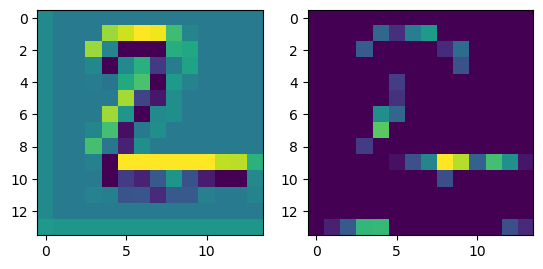

prediction: tensor([4, 6, 5]), tensor([2.5476, 1.5689, 1.0825]) groudtruth: 5
-0.025480967 0.023253258


<Figure size 640x480 with 0 Axes>

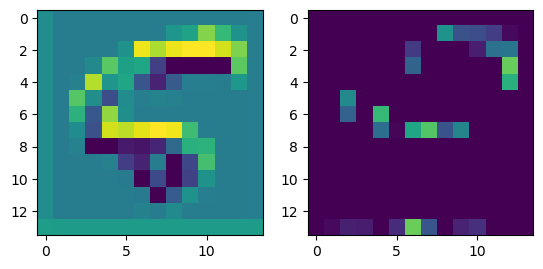

prediction: tensor([8, 7, 3]), tensor([1.9303, 1.5212, 0.4264]) groudtruth: 9
-0.025129456 0.021293124


<Figure size 640x480 with 0 Axes>

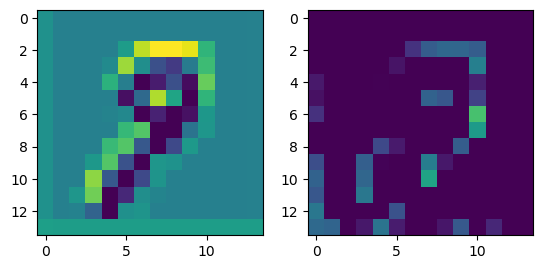

prediction: tensor([7, 2, 9]), tensor([2.6991, 2.3839, 1.1571]) groudtruth: 2
-0.032010924 0.036122978


<Figure size 640x480 with 0 Axes>

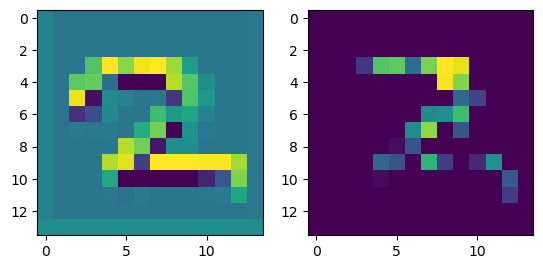

prediction: tensor([9, 4, 7]), tensor([2.5781, 2.5677, 1.2965]) groudtruth: 4
-0.027695574 0.028625589


<Figure size 640x480 with 0 Axes>

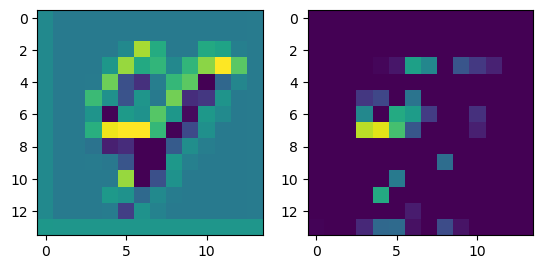

prediction: tensor([2, 3, 5]), tensor([1.5849, 1.4222, 0.7004]) groudtruth: 3
-0.026451398 0.026776716


<Figure size 640x480 with 0 Axes>

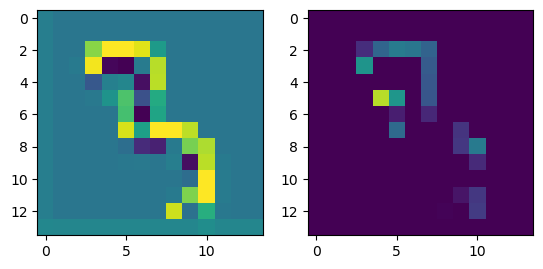

prediction: tensor([0, 6, 5]), tensor([3.5613, 2.5519, 1.1495]) groudtruth: 6
-0.028032389 0.02112203


<Figure size 640x480 with 0 Axes>

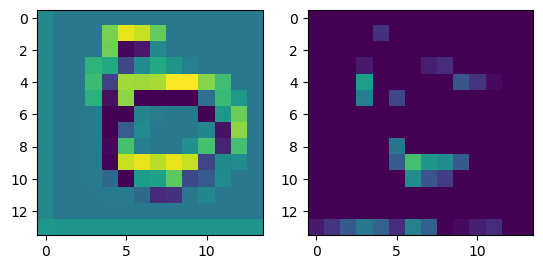

prediction: tensor([1, 7, 8]), tensor([2.8120, 1.6634, 1.4927]) groudtruth: 9
-0.024839938 0.028461752


<Figure size 640x480 with 0 Axes>

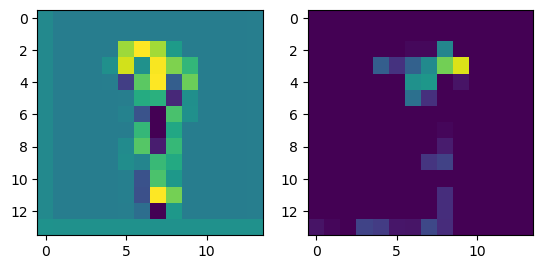

prediction: tensor([8, 7, 1]), tensor([2.1384, 1.7031, 0.9668]) groudtruth: 2
-0.048719235 0.027152387


<Figure size 640x480 with 0 Axes>

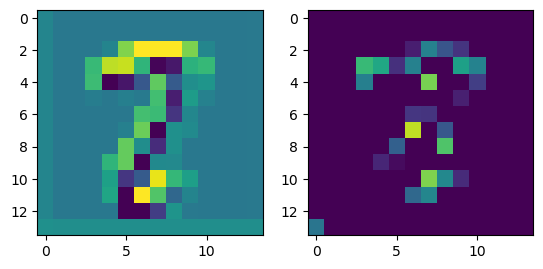

prediction: tensor([9, 4, 7]), tensor([1.8784, 1.5470, 1.1109]) groudtruth: 4
-0.026007902 0.029038321


<Figure size 640x480 with 0 Axes>

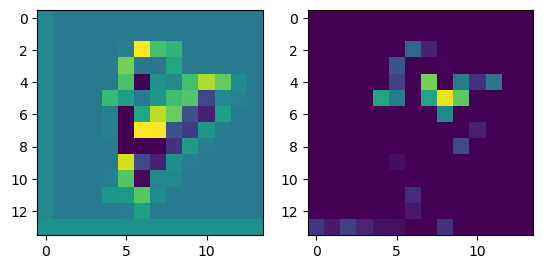

prediction: tensor([8, 3, 9]), tensor([2.3090, 1.0915, 1.0652]) groudtruth: 9
-0.02538561 0.021978568


<Figure size 640x480 with 0 Axes>

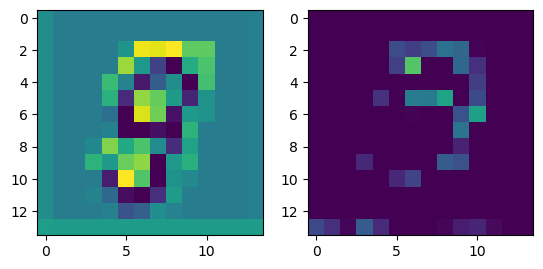

prediction: tensor([5, 3, 0]), tensor([3.6072, 2.5093, 1.3494]) groudtruth: 3
-0.025533345 0.025086066


<Figure size 640x480 with 0 Axes>

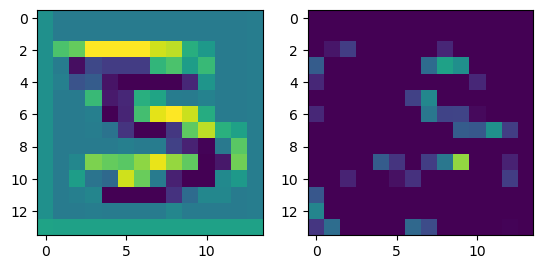

prediction: tensor([8, 1, 2]), tensor([1.6669, 1.4465, 1.2325]) groudtruth: 2
-0.02784682 0.030594105


<Figure size 640x480 with 0 Axes>

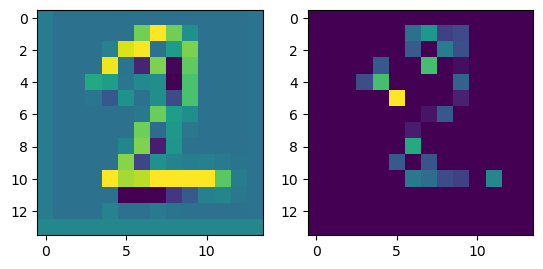

prediction: tensor([9, 7, 5]), tensor([2.3685, 1.8926, 1.7547]) groudtruth: 5
-0.024102 0.034262717


<Figure size 640x480 with 0 Axes>

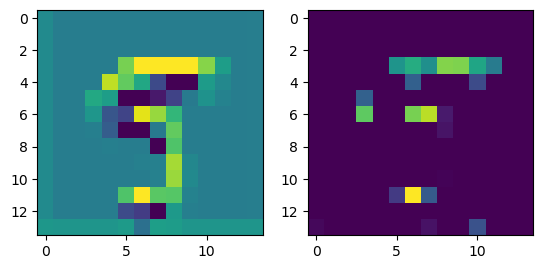

prediction: tensor([2, 0, 8]), tensor([1.2995, 1.1091, 0.5576]) groudtruth: 6
-0.020254644 0.036363594


<Figure size 640x480 with 0 Axes>

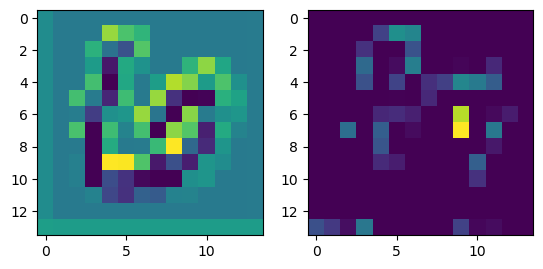

prediction: tensor([8, 4, 1]), tensor([1.6668, 1.2340, 1.1836]) groudtruth: 1
-0.030191436 0.029226486


<Figure size 640x480 with 0 Axes>

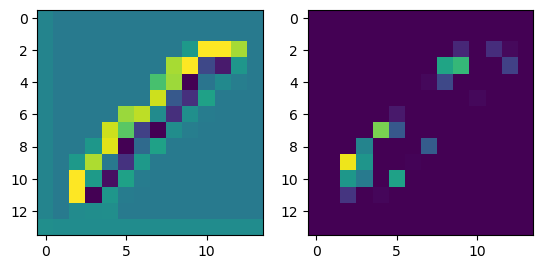

prediction: tensor([8, 2, 7]), tensor([2.3343, 1.2827, 1.1924]) groudtruth: 3
-0.035906274 0.022370158


<Figure size 640x480 with 0 Axes>

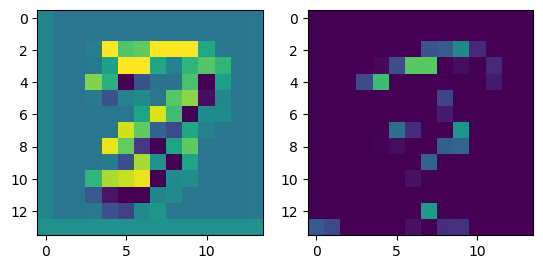

prediction: tensor([2, 8, 3]), tensor([1.5552, 1.3352, 1.0883]) groudtruth: 8
-0.027904494 0.019614276


<Figure size 640x480 with 0 Axes>

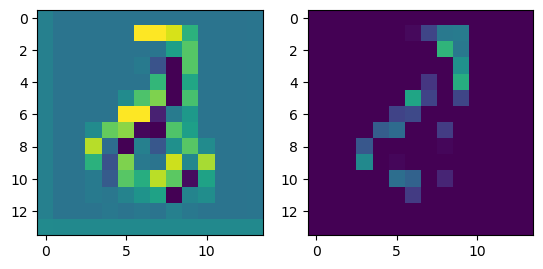

prediction: tensor([3, 2, 8]), tensor([2.0888, 1.1507, 1.0584]) groudtruth: 8
-0.031112995 0.013736427


<Figure size 640x480 with 0 Axes>

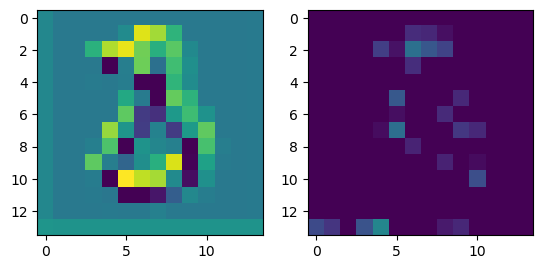

prediction: tensor([6, 3, 5]), tensor([1.3597, 1.2622, 1.1870]) groudtruth: 5
-0.030763386 0.03748381


<Figure size 640x480 with 0 Axes>

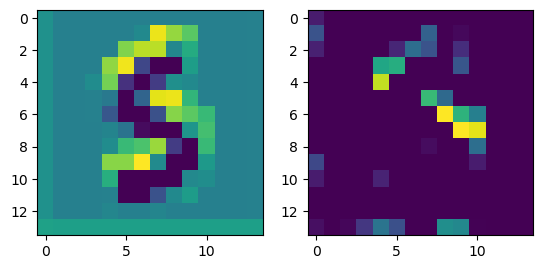

prediction: tensor([6, 2, 1]), tensor([4.1937, 1.7156, 1.3397]) groudtruth: 2
-0.037914976 0.017529553


<Figure size 640x480 with 0 Axes>

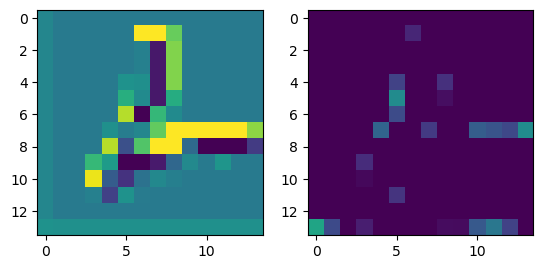

prediction: tensor([0, 5, 8]), tensor([2.9361, 2.1803, 1.6129]) groudtruth: 5
-0.034242075 0.03343281


<Figure size 640x480 with 0 Axes>

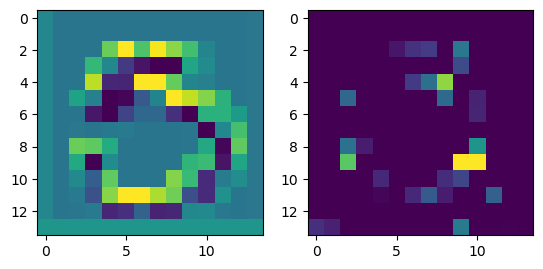

prediction: tensor([9, 4, 8]), tensor([2.8338, 1.8552, 1.1945]) groudtruth: 4
-0.020323608 0.022041928


<Figure size 640x480 with 0 Axes>

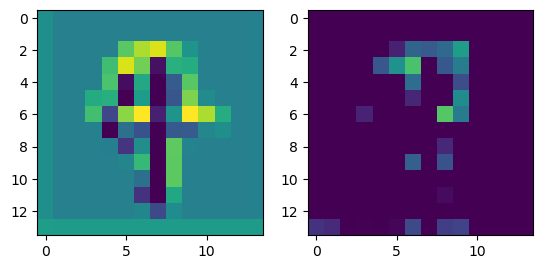

prediction: tensor([9, 4, 8]), tensor([3.2422, 2.5594, 0.2322]) groudtruth: 4
-0.022752073 0.022707555


<Figure size 640x480 with 0 Axes>

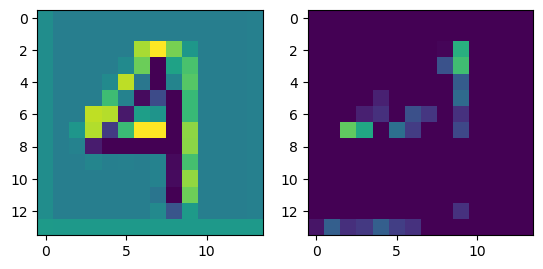

prediction: tensor([6, 0, 5]), tensor([2.5330, 1.8469, 1.2882]) groudtruth: 0
-0.035801116 0.026943969


<Figure size 640x480 with 0 Axes>

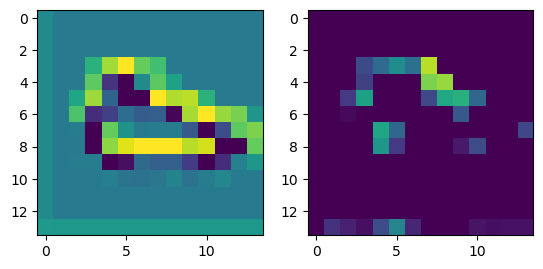

prediction: tensor([9, 8, 4]), tensor([2.4717, 1.9219, 1.7764]) groudtruth: 4
-0.022151688 0.030683806


<Figure size 640x480 with 0 Axes>

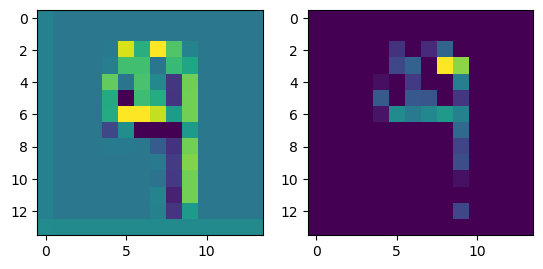

prediction: tensor([9, 7, 4]), tensor([3.0289, 2.8104, 1.0195]) groudtruth: 7
-0.036897402 0.024431266


<Figure size 640x480 with 0 Axes>

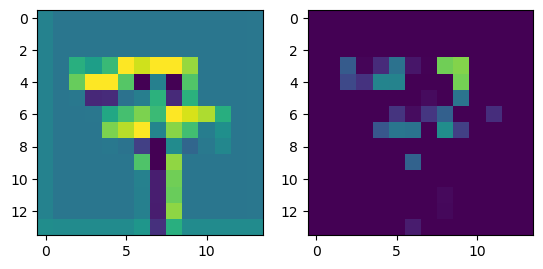

prediction: tensor([3, 8, 5]), tensor([3.0524, 1.2948, 1.0025]) groudtruth: 8
-0.037725538 0.03248577


<Figure size 640x480 with 0 Axes>

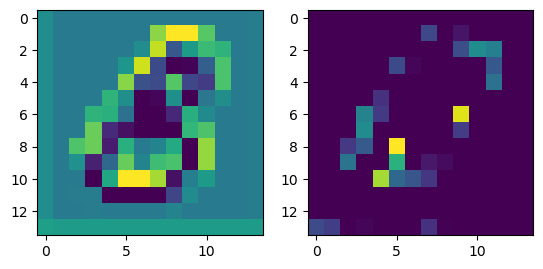

prediction: tensor([7, 3, 8]), tensor([2.1960, 1.1533, 0.6761]) groudtruth: 8
-0.031688973 0.038730893


<Figure size 640x480 with 0 Axes>

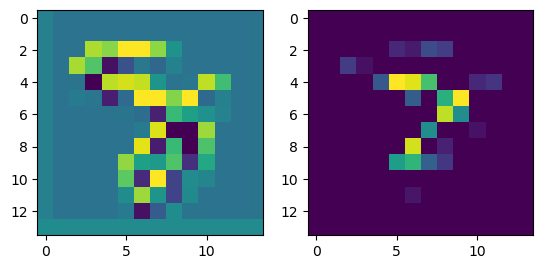

prediction: tensor([8, 1, 3]), tensor([1.2067, 1.0232, 0.9347]) groudtruth: 7
-0.028353628 0.01995772


<Figure size 640x480 with 0 Axes>

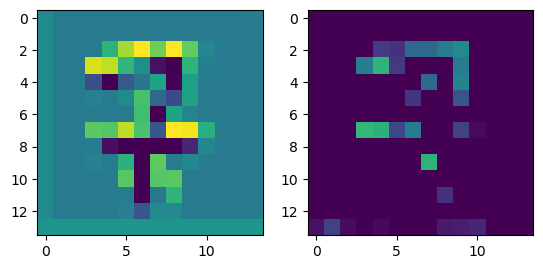

prediction: tensor([9, 7, 4]), tensor([1.7402, 1.6374, 1.6043]) groudtruth: 7
-0.03192222 0.017719947


<Figure size 640x480 with 0 Axes>

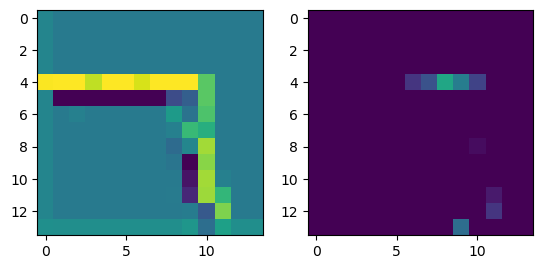

prediction: tensor([9, 7, 4]), tensor([2.5093, 1.7641, 1.6141]) groudtruth: 7
-0.027752182 0.03029707


<Figure size 640x480 with 0 Axes>

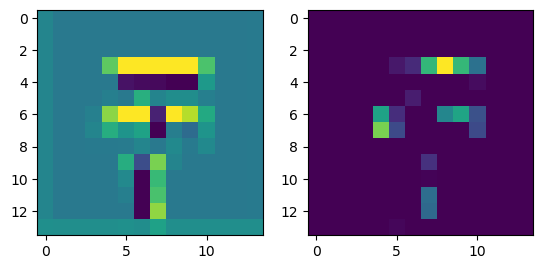

prediction: tensor([0, 5, 6]), tensor([3.5532, 1.7871, 0.8273]) groudtruth: 6
-0.021261625 0.019359956


<Figure size 640x480 with 0 Axes>

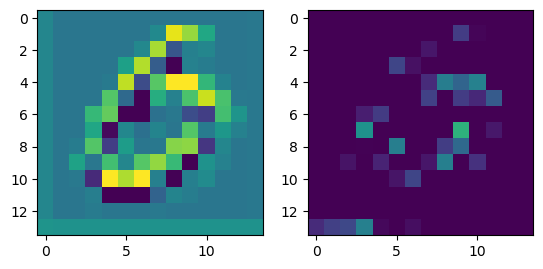

prediction: tensor([8, 4, 7]), tensor([2.3045, 1.7909, 0.6985]) groudtruth: 4
-0.038666002 0.028934946


<Figure size 640x480 with 0 Axes>

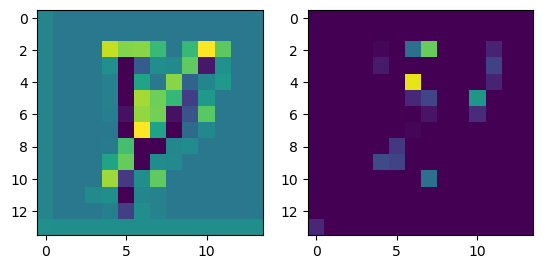

prediction: tensor([5, 3, 6]), tensor([2.4049, 2.0173, 0.6982]) groudtruth: 3
-0.027962884 0.027489992


<Figure size 640x480 with 0 Axes>

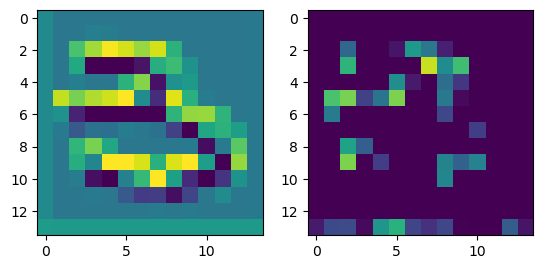

prediction: tensor([1, 8, 3]), tensor([1.5431, 1.4281, 1.0536]) groudtruth: 8
-0.023723938 0.016935516


<Figure size 640x480 with 0 Axes>

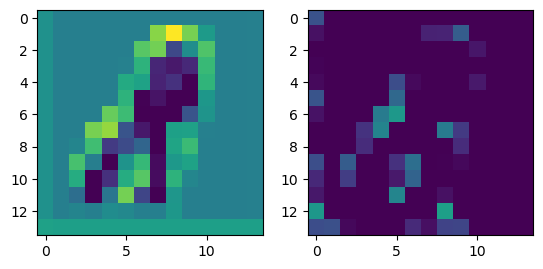

prediction: tensor([9, 4, 1]), tensor([2.2778, 1.7118, 1.6122]) groudtruth: 7
-0.024712143 0.012771462


<Figure size 640x480 with 0 Axes>

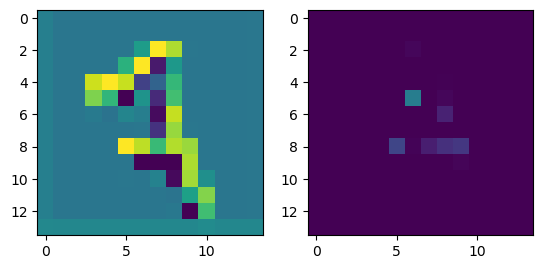

prediction: tensor([8, 7, 2]), tensor([1.3757, 1.0734, 0.8631]) groudtruth: 7
-0.035726316 0.027432375


<Figure size 640x480 with 0 Axes>

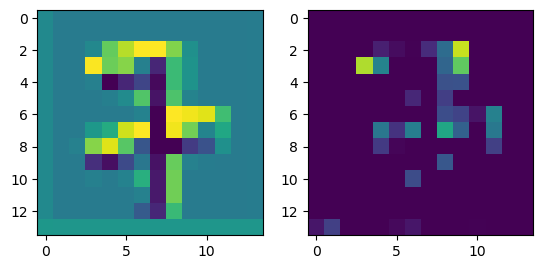

prediction: tensor([9, 7, 0]), tensor([3.1618, 2.6874, 2.0280]) groudtruth: 7
-0.032187436 0.026833985


<Figure size 640x480 with 0 Axes>

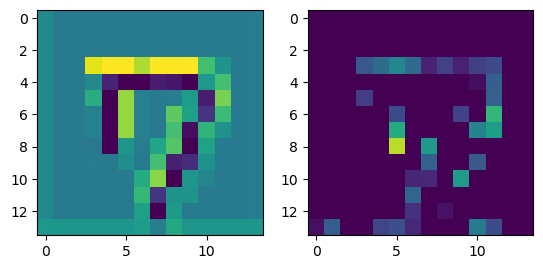

prediction: tensor([6, 8, 9]), tensor([1.4189, 1.1227, 0.8141]) groudtruth: 8
-0.039375976 0.03372793


<Figure size 640x480 with 0 Axes>

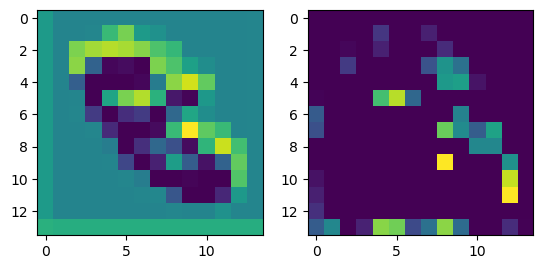

prediction: tensor([5, 6, 8]), tensor([1.6514, 1.6494, 0.9871]) groudtruth: 6
-0.025818877 0.017182577


<Figure size 640x480 with 0 Axes>

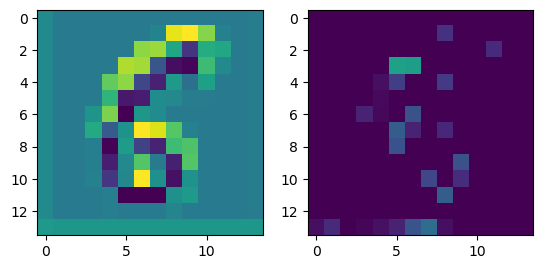

prediction: tensor([9, 4, 8]), tensor([2.0507, 1.7287, 0.8867]) groudtruth: 4
-0.020686641 0.031101068


<Figure size 640x480 with 0 Axes>

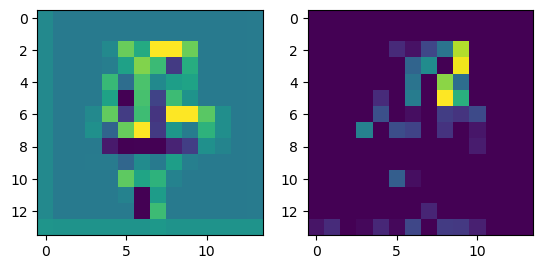

prediction: tensor([8, 7, 4]), tensor([1.3764, 0.5092, 0.4779]) groudtruth: 4
-0.020728718 0.015857704


<Figure size 640x480 with 0 Axes>

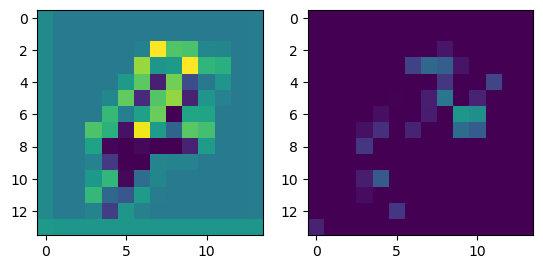

prediction: tensor([6, 2, 5]), tensor([2.1589, 1.9658, 1.8432]) groudtruth: 2
-0.036813255 0.025614329


<Figure size 640x480 with 0 Axes>

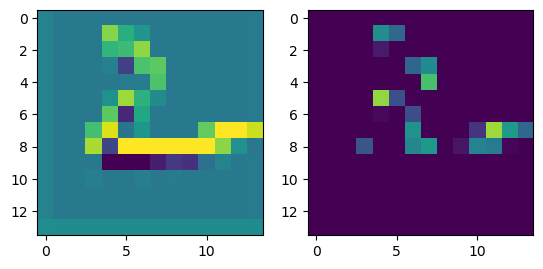

prediction: tensor([2, 7, 3]), tensor([2.5532, 1.1415, 0.9632]) groudtruth: 7
-0.021870242 0.0153619405


<Figure size 640x480 with 0 Axes>

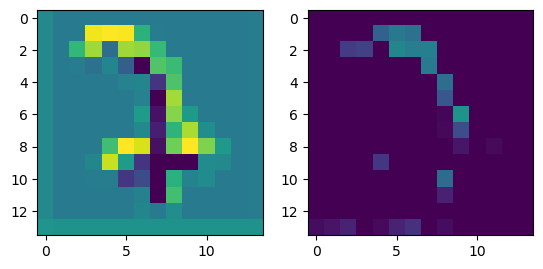

prediction: tensor([2, 3, 4]), tensor([2.6327, 1.0523, 1.0052]) groudtruth: 7
-0.03745988 0.02895249


<Figure size 640x480 with 0 Axes>

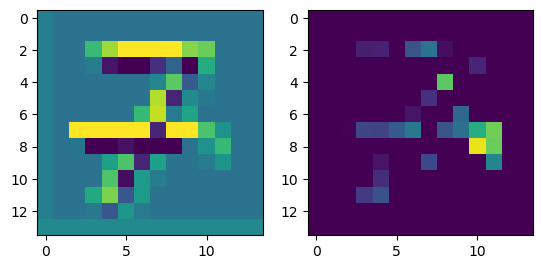

prediction: tensor([6, 0, 8]), tensor([1.0891, 0.6476, 0.5560]) groudtruth: 0
-0.026532605 0.02159397


<Figure size 640x480 with 0 Axes>

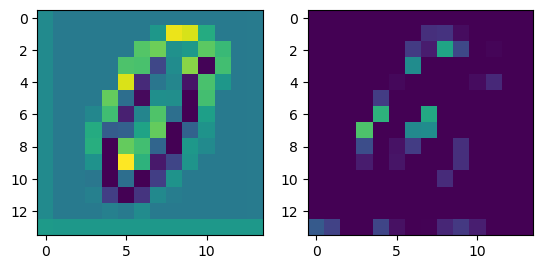

prediction: tensor([9, 4, 5]), tensor([1.5485, 1.5158, 0.8651]) groudtruth: 5
-0.022356642 0.020199906


<Figure size 640x480 with 0 Axes>

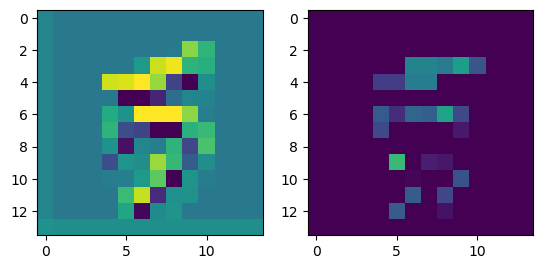

prediction: tensor([5, 3, 6]), tensor([2.2931, 1.4698, 1.2351]) groudtruth: 3
-0.021230323 0.026384745


<Figure size 640x480 with 0 Axes>

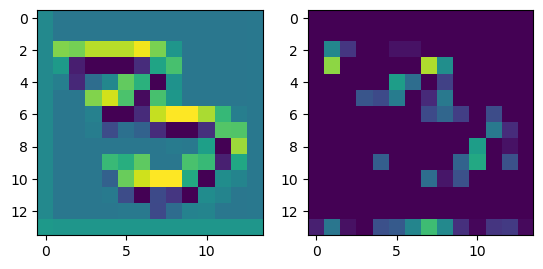

prediction: tensor([1, 6, 5]), tensor([2.3913, 1.7235, 0.8952]) groudtruth: 6
-0.018934514 0.011564596


<Figure size 640x480 with 0 Axes>

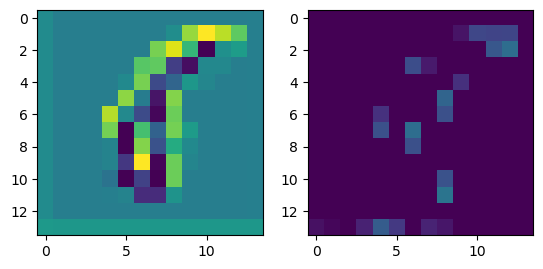

prediction: tensor([6, 2, 5]), tensor([2.1139, 0.7402, 0.6260]) groudtruth: 2
-0.041946694 0.036903486


<Figure size 640x480 with 0 Axes>

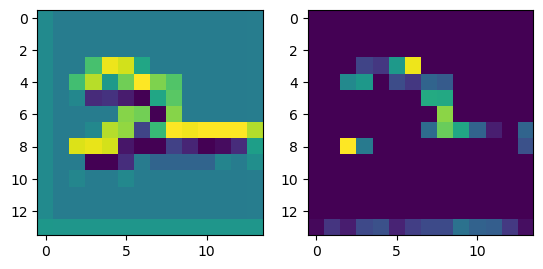

prediction: tensor([9, 7, 4]), tensor([3.8634, 2.7004, 1.8372]) groudtruth: 7
-0.021491783 0.024021162


<Figure size 640x480 with 0 Axes>

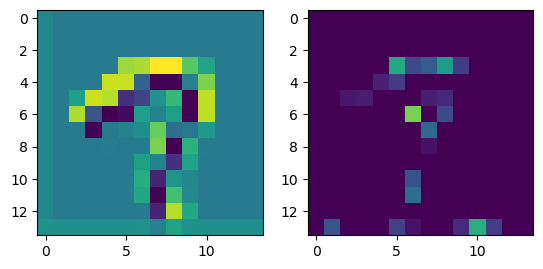

prediction: tensor([8, 2, 7]), tensor([1.5884, 1.1952, 0.5887]) groudtruth: 2
-0.025444608 0.021568054


<Figure size 640x480 with 0 Axes>

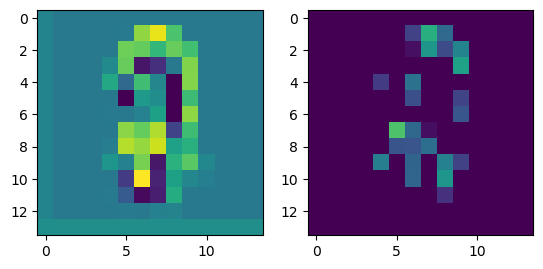

prediction: tensor([1, 2, 8]), tensor([2.9404, 1.6953, 1.3763]) groudtruth: 2
-0.052718107 0.030738493


<Figure size 640x480 with 0 Axes>

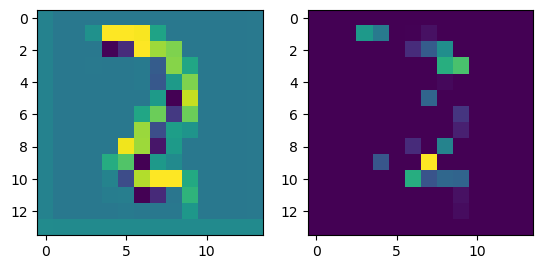

prediction: tensor([6, 2, 1]), tensor([2.9826, 1.9832, 0.7778]) groudtruth: 2
-0.03519451 0.03541015


<Figure size 640x480 with 0 Axes>

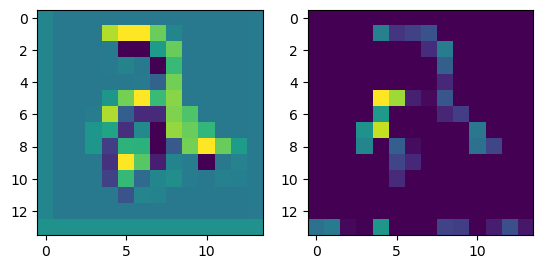

prediction: tensor([8, 0, 9]), tensor([2.3201, 2.0788, 0.6923]) groudtruth: 0
-0.033775397 0.023545181


<Figure size 640x480 with 0 Axes>

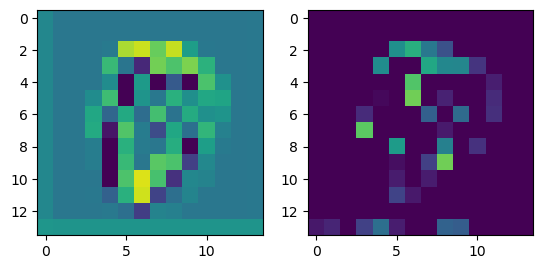

prediction: tensor([6, 5, 8]), tensor([2.6803, 1.6655, 1.6531]) groudtruth: 8
-0.025683772 0.037764672


<Figure size 640x480 with 0 Axes>

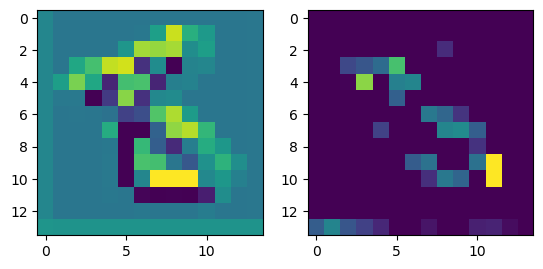

prediction: tensor([3, 0, 5]), tensor([2.1232, 1.8432, 1.3923]) groudtruth: 5
-0.02612874 0.024501879


<Figure size 640x480 with 0 Axes>

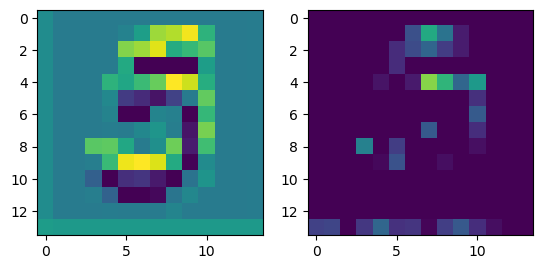

prediction: tensor([9, 4, 8]), tensor([2.3960, 2.1474, 1.8713]) groudtruth: 4
-0.02289471 0.023967128


<Figure size 640x480 with 0 Axes>

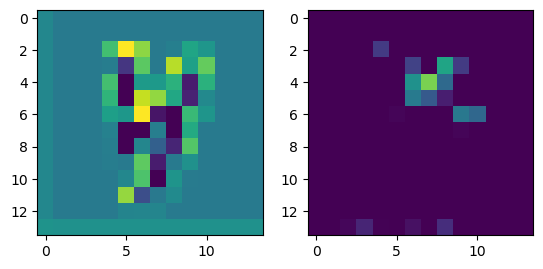

prediction: tensor([6, 2, 8]), tensor([2.6606, 0.9969, 0.7736]) groudtruth: 4
-0.039195783 0.027619628


<Figure size 640x480 with 0 Axes>

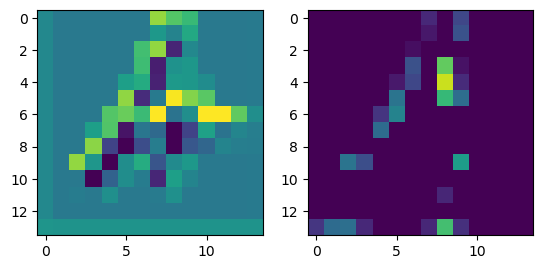

prediction: tensor([7, 3, 5]), tensor([1.5690, 1.2068, 0.5883]) groudtruth: 3
-0.029047783 0.024310583


<Figure size 640x480 with 0 Axes>

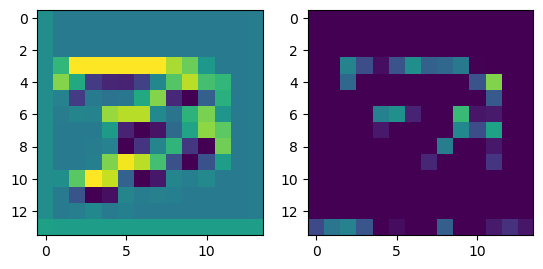

prediction: tensor([6, 0, 5]), tensor([2.1272, 1.6982, 1.4221]) groudtruth: 2
-0.034712337 0.022270355


<Figure size 640x480 with 0 Axes>

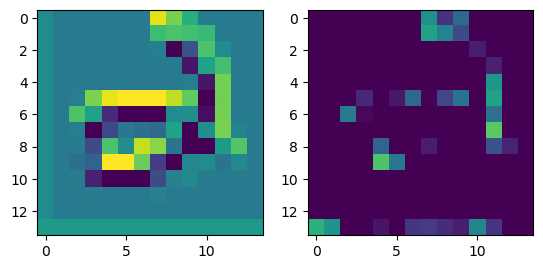

prediction: tensor([9, 4, 7]), tensor([2.5244, 1.7946, 1.0994]) groudtruth: 4
-0.026143974 0.034277815


<Figure size 640x480 with 0 Axes>

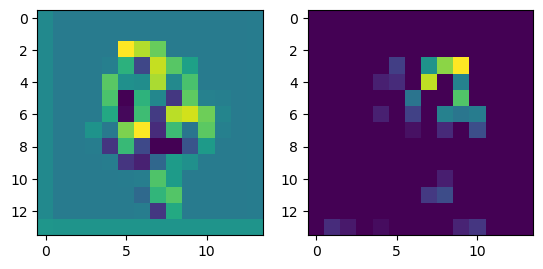

prediction: tensor([9, 3, 7]), tensor([1.1916, 1.1020, 0.5561]) groudtruth: 2
-0.032794997 0.022515994


<Figure size 640x480 with 0 Axes>

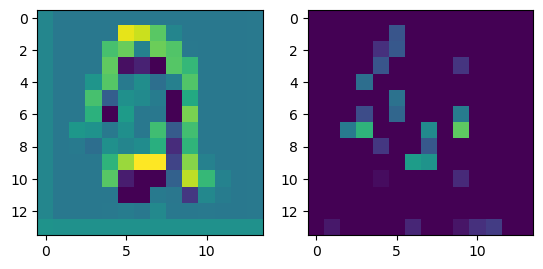

prediction: tensor([9, 1, 4]), tensor([2.3781, 2.0802, 1.8514]) groudtruth: 4
-0.023782838 0.02287174


<Figure size 640x480 with 0 Axes>

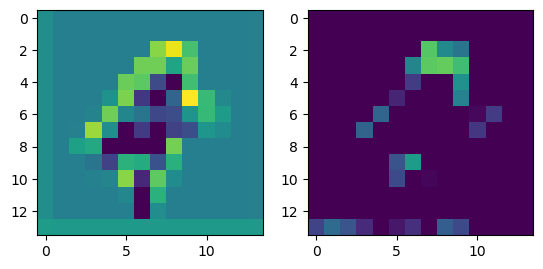

prediction: tensor([4, 8, 1]), tensor([2.1034, 1.7897, 1.0177]) groudtruth: 1
-0.02683683 0.015859457


<Figure size 640x480 with 0 Axes>

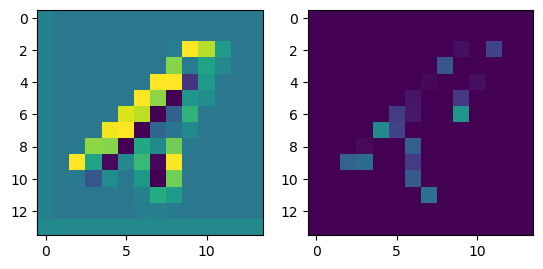

prediction: tensor([5, 3, 8]), tensor([1.8380, 1.4109, 1.1212]) groudtruth: 3
-0.03216567 0.026876703


<Figure size 640x480 with 0 Axes>

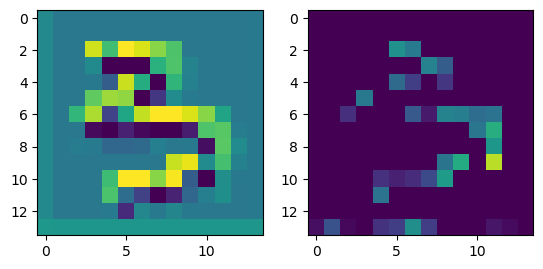

prediction: tensor([3, 5, 8]), tensor([2.4981, 2.4776, 1.0689]) groudtruth: 5
-0.039577387 0.038392674


<Figure size 640x480 with 0 Axes>

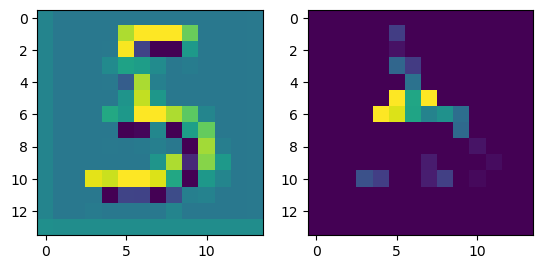

prediction: tensor([0, 2, 6]), tensor([3.5400, 2.4445, 1.6465]) groudtruth: 2
-0.030718628 0.02789968


<Figure size 640x480 with 0 Axes>

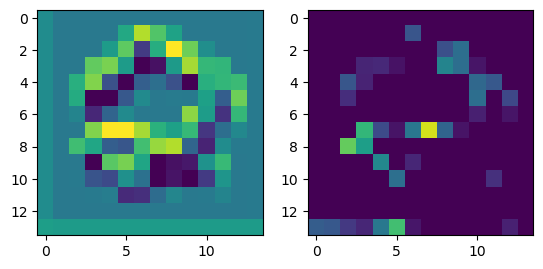

prediction: tensor([9, 6, 4]), tensor([1.7356, 1.4959, 1.4074]) groudtruth: 4
-0.021271922 0.021477964


<Figure size 640x480 with 0 Axes>

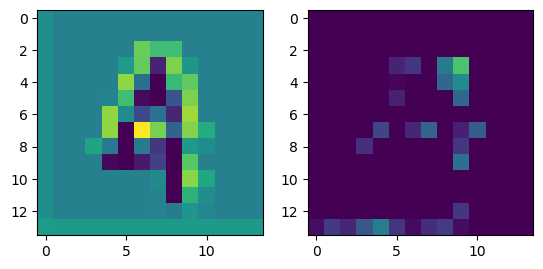

prediction: tensor([8, 1, 2]), tensor([2.0019, 1.8525, 1.2159]) groudtruth: 1
-0.032905877 0.02189951


<Figure size 640x480 with 0 Axes>

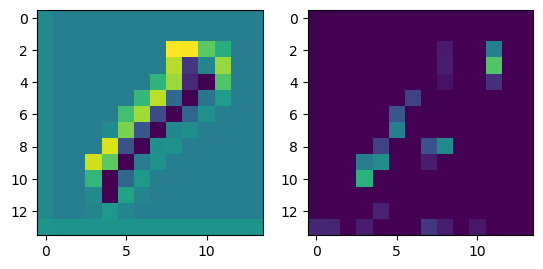

prediction: tensor([9, 4, 7]), tensor([3.0403, 2.0197, 1.1894]) groudtruth: 4
-0.02363905 0.03900253


<Figure size 640x480 with 0 Axes>

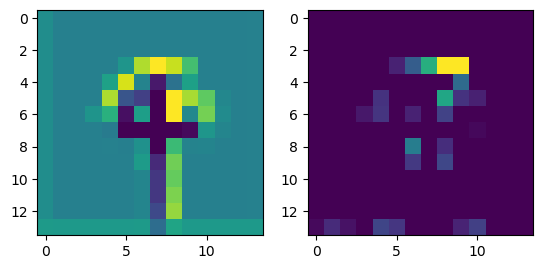

prediction: tensor([2, 6, 4]), tensor([1.5673, 0.9853, 0.9678]) groudtruth: 6
-0.02942547 0.02723112


<Figure size 640x480 with 0 Axes>

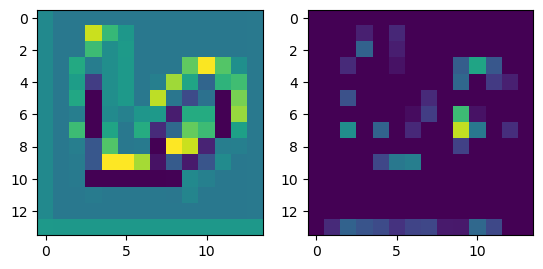

prediction: tensor([3, 5, 0]), tensor([1.9627, 1.9508, 1.7336]) groudtruth: 6
-0.028632224 0.02623237


<Figure size 640x480 with 0 Axes>

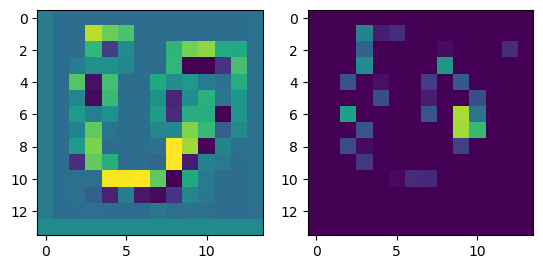

prediction: tensor([9, 5, 8]), tensor([1.9124, 1.8695, 1.3792]) groudtruth: 5
-0.033610344 0.025200214


<Figure size 640x480 with 0 Axes>

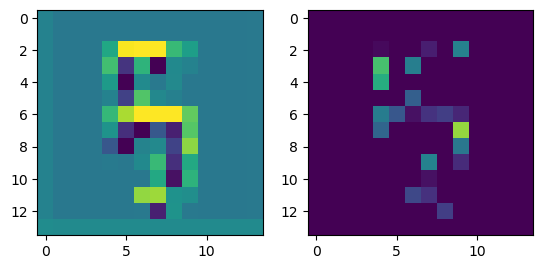

prediction: tensor([3, 6, 8]), tensor([1.1549, 1.0942, 0.6454]) groudtruth: 8
-0.025345018 0.04273483


<Figure size 640x480 with 0 Axes>

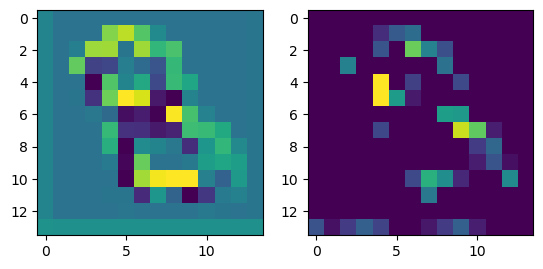

prediction: tensor([2, 3, 8]), tensor([1.5259, 1.5015, 1.1841]) groudtruth: 1
-0.04261925 0.033211336


<Figure size 640x480 with 0 Axes>

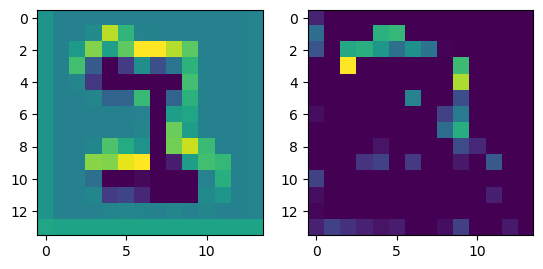

prediction: tensor([8, 3, 9]), tensor([2.0985, 0.5693, 0.2934]) groudtruth: 0
-0.027255319 0.04235041


<Figure size 640x480 with 0 Axes>

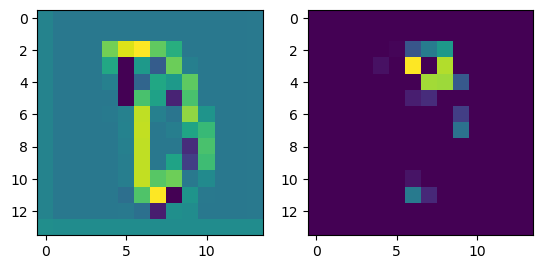

prediction: tensor([0, 5, 3]), tensor([3.1352, 2.8541, 2.4296]) groudtruth: 2
-0.03108782 0.018346017


<Figure size 640x480 with 0 Axes>

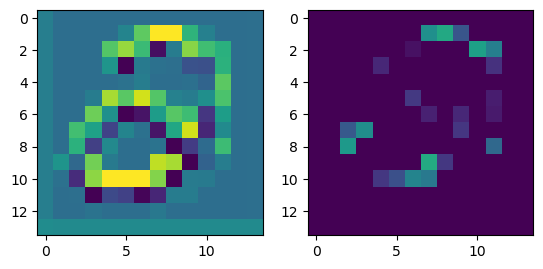

prediction: tensor([1, 8, 7]), tensor([3.3080, 1.4152, 1.0111]) groudtruth: 9
-0.027569517 0.033341102


<Figure size 640x480 with 0 Axes>

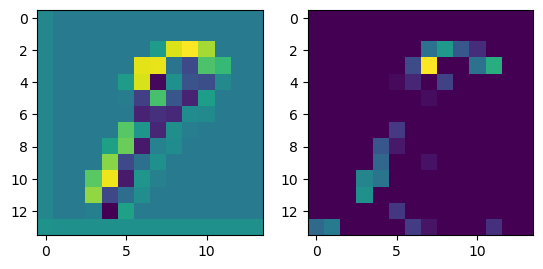

prediction: tensor([1, 8, 3]), tensor([1.7216, 1.6488, 0.6413]) groudtruth: 3
-0.03399546 0.032743234


<Figure size 640x480 with 0 Axes>

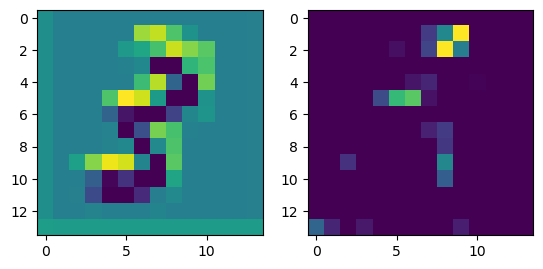

prediction: tensor([6, 5, 9]), tensor([1.9727, 1.2119, 1.2016]) groudtruth: 5
-0.03025779 0.023939382


<Figure size 640x480 with 0 Axes>

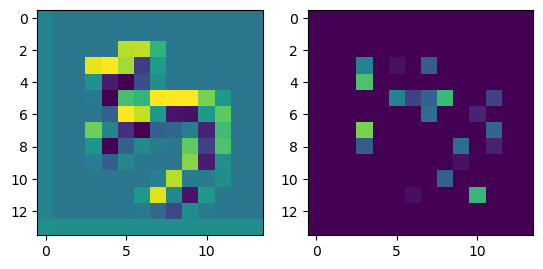

prediction: tensor([2, 9, 6]), tensor([2.2245, 1.3639, 1.1935]) groudtruth: 9
-0.037872374 0.025559384


<Figure size 640x480 with 0 Axes>

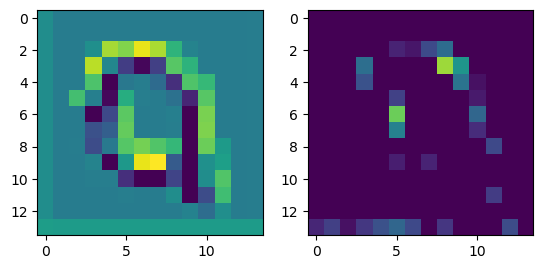

prediction: tensor([4, 5, 9]), tensor([2.8446, 2.6406, 2.2624]) groudtruth: 5
-0.028480869 0.0337945


<Figure size 640x480 with 0 Axes>

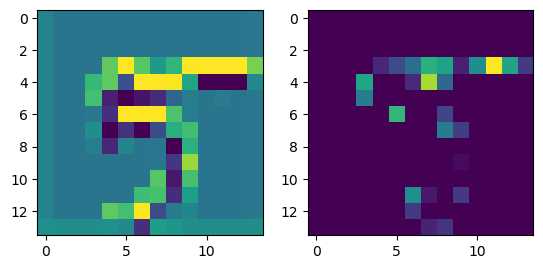

prediction: tensor([9, 4, 7]), tensor([3.2481, 1.9555, 1.3394]) groudtruth: 4
-0.026443573 0.021513343


<Figure size 640x480 with 0 Axes>

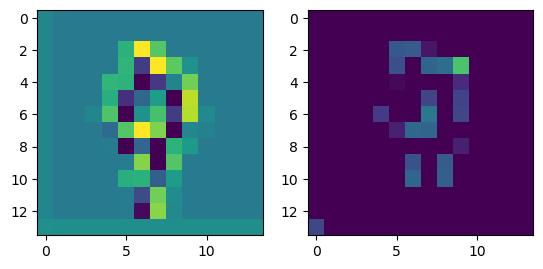

prediction: tensor([2, 7, 9]), tensor([1.6152, 1.4094, 1.2583]) groudtruth: 7
-0.026842237 0.021905068


<Figure size 640x480 with 0 Axes>

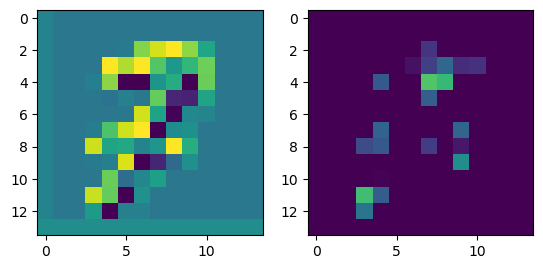

prediction: tensor([1, 7, 8]), tensor([1.9984, 1.8609, 1.0622]) groudtruth: 7
-0.026994498 0.026594248


<Figure size 640x480 with 0 Axes>

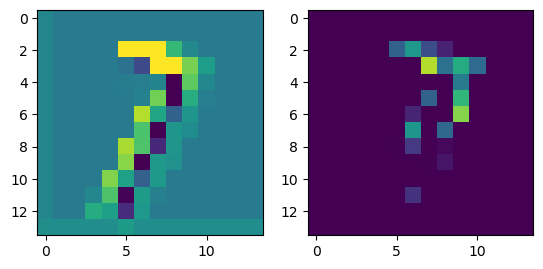

prediction: tensor([3, 5, 0]), tensor([2.9947, 2.4210, 1.0200]) groudtruth: 5
-0.034381125 0.033092216


<Figure size 640x480 with 0 Axes>

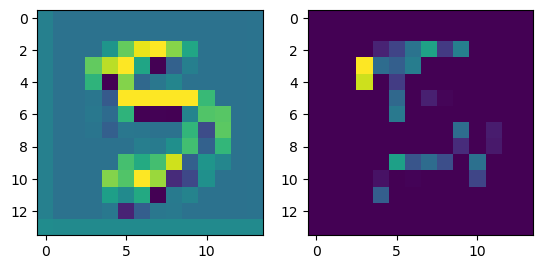

prediction: tensor([8, 3, 9]), tensor([1.3759, 0.9296, 0.7187]) groudtruth: 0
-0.028512085 0.021999527


<Figure size 640x480 with 0 Axes>

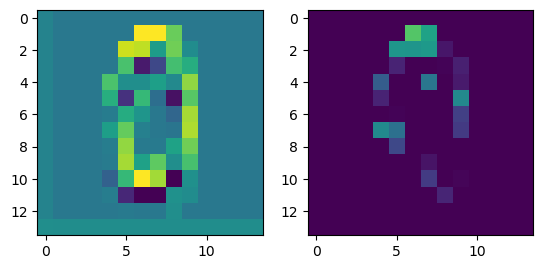

prediction: tensor([8, 1, 5]), tensor([2.0815, 1.5169, 1.3407]) groudtruth: 5
-0.031782627 0.02483736


<Figure size 640x480 with 0 Axes>

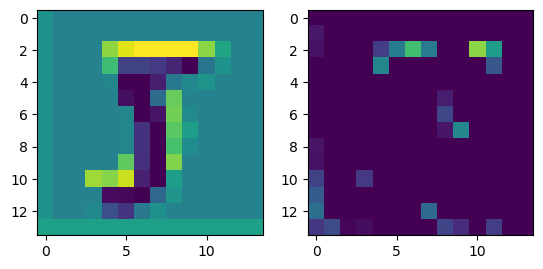

prediction: tensor([0, 5, 7]), tensor([2.0125, 1.9246, 1.7426]) groudtruth: 5
-0.039647944 0.0383474


<Figure size 640x480 with 0 Axes>

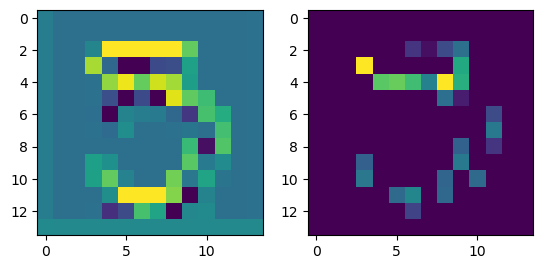

prediction: tensor([2, 8, 7]), tensor([2.3806, 1.1568, 1.1553]) groudtruth: 7
-0.024341023 0.02385151


<Figure size 640x480 with 0 Axes>

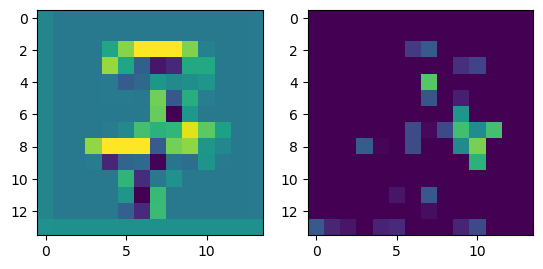

prediction: tensor([6, 0, 8]), tensor([2.7410, 1.3039, 0.6655]) groudtruth: 0
-0.02840963 0.018828796


<Figure size 640x480 with 0 Axes>

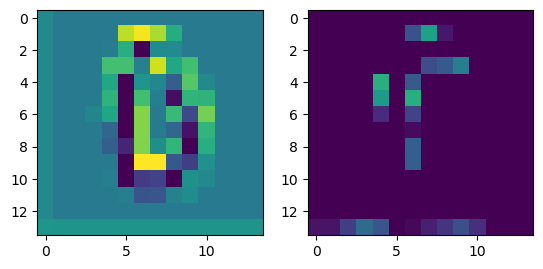

prediction: tensor([6, 7, 4]), tensor([1.8031, 0.7670, 0.6082]) groudtruth: 2
-0.0328013 0.033256996


<Figure size 640x480 with 0 Axes>

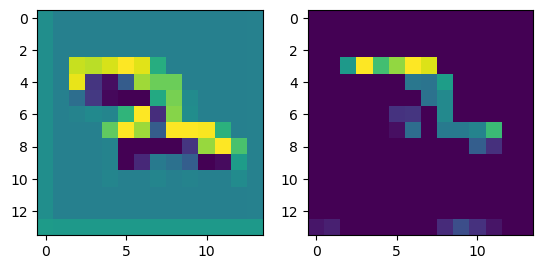

prediction: tensor([4, 9, 6]), tensor([2.1645, 1.5629, 1.2415]) groudtruth: 7
-0.019950906 0.020601029


<Figure size 640x480 with 0 Axes>

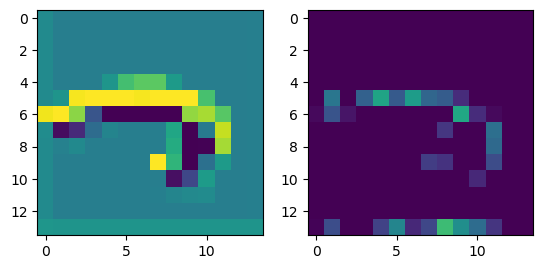

prediction: tensor([0, 6, 4]), tensor([3.0399, 1.9828, 0.5894]) groudtruth: 6
-0.019879226 0.014376634


<Figure size 640x480 with 0 Axes>

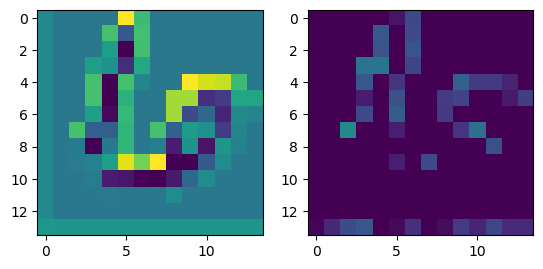

prediction: tensor([0, 6, 2]), tensor([3.3369, 3.2305, 1.0730]) groudtruth: 6
-0.018533444 0.012337974


<Figure size 640x480 with 0 Axes>

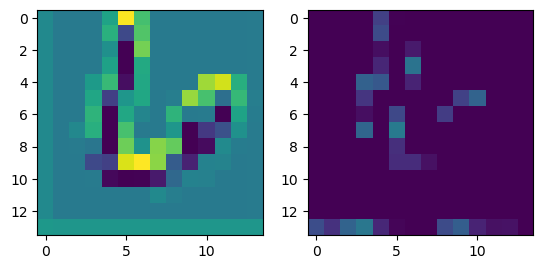

prediction: tensor([8, 9, 1]), tensor([1.4680, 1.2232, 0.7271]) groudtruth: 9
-0.023955802 0.014506212


<Figure size 640x480 with 0 Axes>

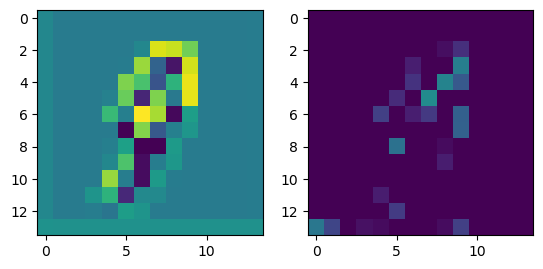

prediction: tensor([8, 1, 5]), tensor([2.0618, 1.8710, 0.9661]) groudtruth: 1
-0.029935189 0.032628335


<Figure size 640x480 with 0 Axes>

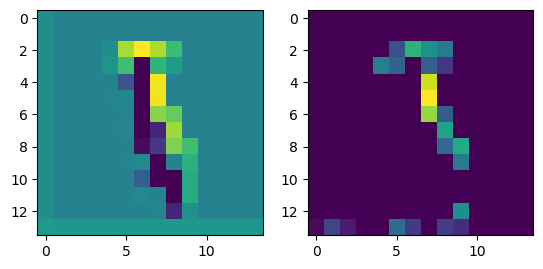

prediction: tensor([7, 3, 5]), tensor([2.3785, 2.0328, 0.6319]) groudtruth: 3
-0.021938087 0.02470405


<Figure size 640x480 with 0 Axes>

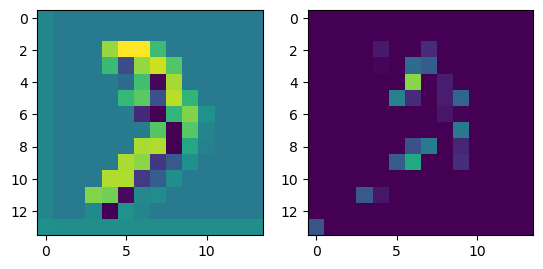

prediction: tensor([8, 1, 0]), tensor([1.7493, 1.5466, 0.4825]) groudtruth: 1
-0.031846896 0.025810111


<Figure size 640x480 with 0 Axes>

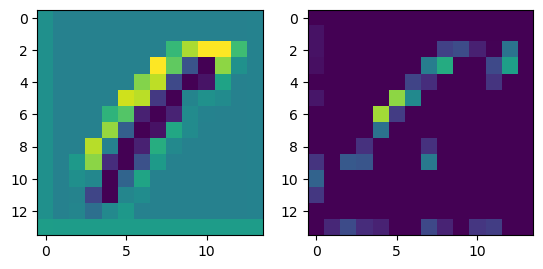

prediction: tensor([5, 7, 8]), tensor([1.4425, 1.1516, 0.8669]) groudtruth: 3
-0.02440821 0.028097393


<Figure size 640x480 with 0 Axes>

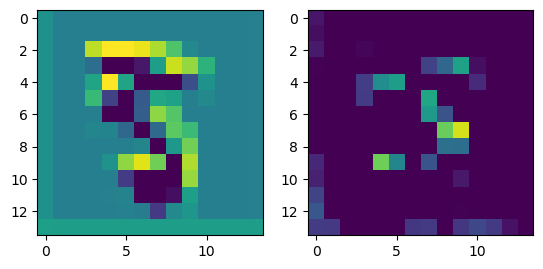

prediction: tensor([6, 8, 5]), tensor([1.7453, 1.4434, 1.3591]) groudtruth: 8
-0.02631272 0.018570181


<Figure size 640x480 with 0 Axes>

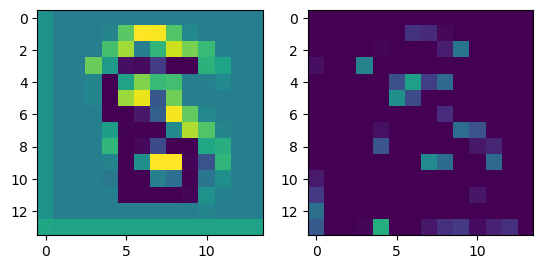

prediction: tensor([2, 3, 5]), tensor([2.8235, 2.1828, 0.9232]) groudtruth: 1
-0.026850734 0.044631492


<Figure size 640x480 with 0 Axes>

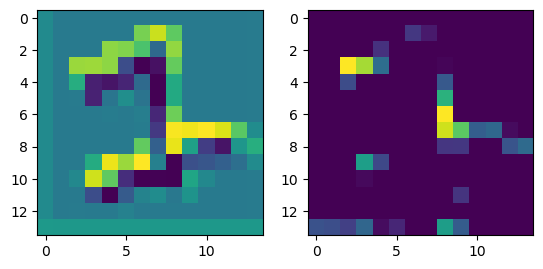

prediction: tensor([9, 7, 8]), tensor([3.8518, 3.3521, 1.0510]) groudtruth: 7
-0.026440522 0.020241968


<Figure size 640x480 with 0 Axes>

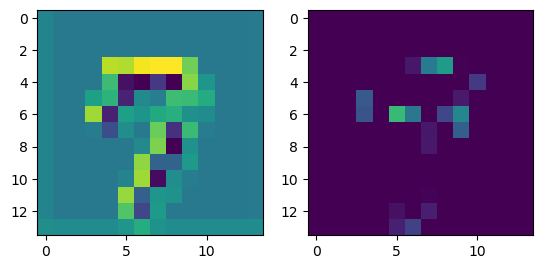

prediction: tensor([4, 9, 8]), tensor([1.2574, 1.2003, 1.0811]) groudtruth: 7
-0.028680095 0.026127055


<Figure size 640x480 with 0 Axes>

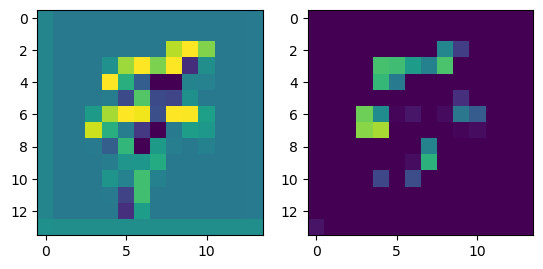

prediction: tensor([0, 3, 5]), tensor([4.7269, 3.4422, 2.0702]) groudtruth: 3
-0.024825983 0.02606479


<Figure size 640x480 with 0 Axes>

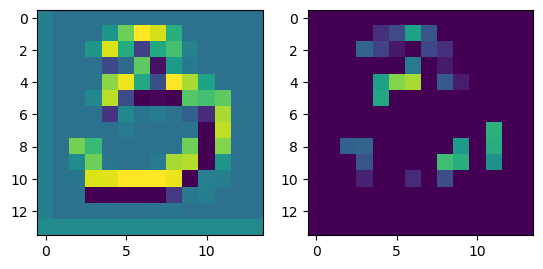

prediction: tensor([3, 2, 8]), tensor([2.7717, 1.9627, 1.7080]) groudtruth: 8
-0.027511846 0.036602616


<Figure size 640x480 with 0 Axes>

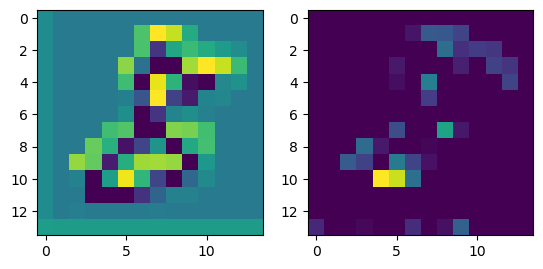

prediction: tensor([9, 5, 4]), tensor([2.4783, 2.1285, 1.1219]) groudtruth: 5
-0.034280222 0.03597667


<Figure size 640x480 with 0 Axes>

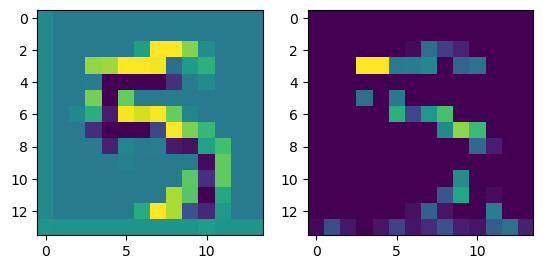

prediction: tensor([9, 5, 3]), tensor([1.8813, 1.2915, 1.2130]) groudtruth: 3
-0.030534586 0.03421521


<Figure size 640x480 with 0 Axes>

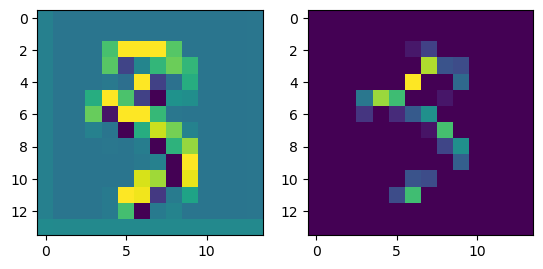

prediction: tensor([3, 8, 5]), tensor([2.3781, 0.9897, 0.7040]) groudtruth: 8
-0.02169889 0.028541323


<Figure size 640x480 with 0 Axes>

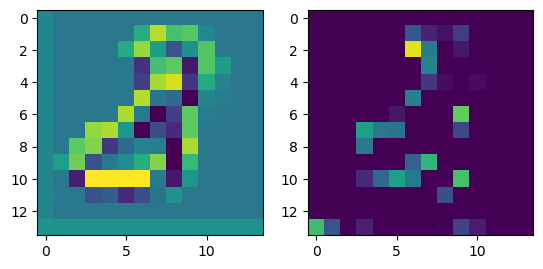

prediction: tensor([1, 2, 6]), tensor([2.1721, 2.1372, 1.7991]) groudtruth: 2
-0.025985444 0.029679973


<Figure size 640x480 with 0 Axes>

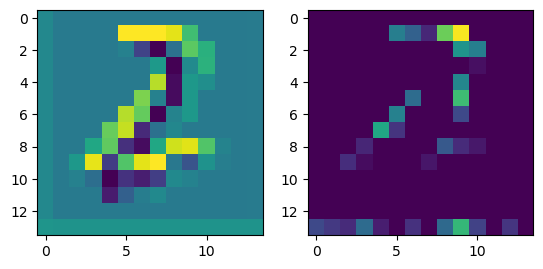

prediction: tensor([5, 0, 8]), tensor([1.7852, 1.4627, 0.8486]) groudtruth: 6
-0.020186588 0.015023951


<Figure size 640x480 with 0 Axes>

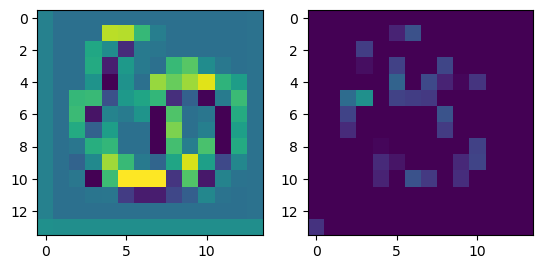

prediction: tensor([3, 5, 0]), tensor([2.4272, 2.1673, 2.0582]) groudtruth: 5
-0.023519732 0.02362451


<Figure size 640x480 with 0 Axes>

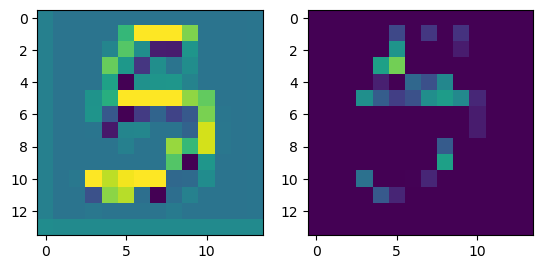

prediction: tensor([3, 8, 2]), tensor([1.5746, 1.2084, 1.2015]) groudtruth: 7
-0.036455516 0.03464873


<Figure size 640x480 with 0 Axes>

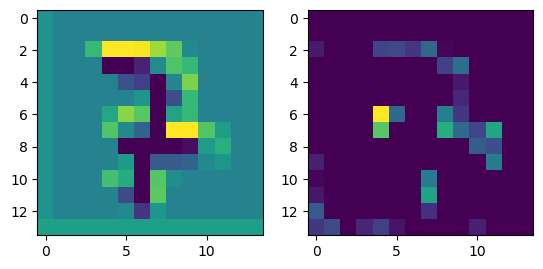

prediction: tensor([0, 3, 2]), tensor([3.7779, 2.8122, 1.8378]) groudtruth: 2
-0.0327068 0.024191152


<Figure size 640x480 with 0 Axes>

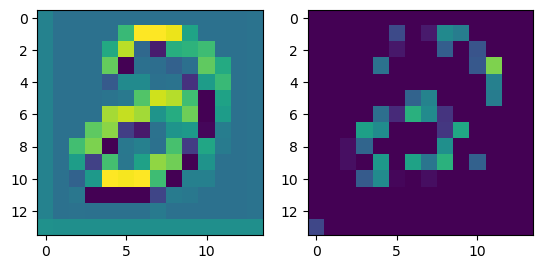

prediction: tensor([9, 4, 7]), tensor([3.0784, 1.6815, 1.0638]) groudtruth: 7
-0.026774157 0.029321816


<Figure size 640x480 with 0 Axes>

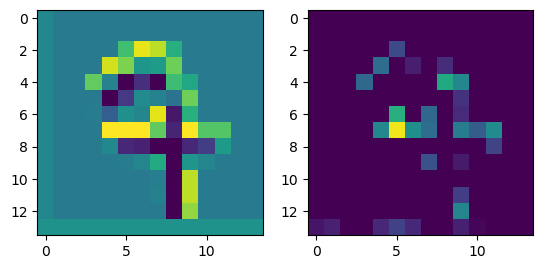

prediction: tensor([9, 7, 4]), tensor([2.8972, 2.5949, 1.7331]) groudtruth: 5
-0.030033555 0.020975351


<Figure size 640x480 with 0 Axes>

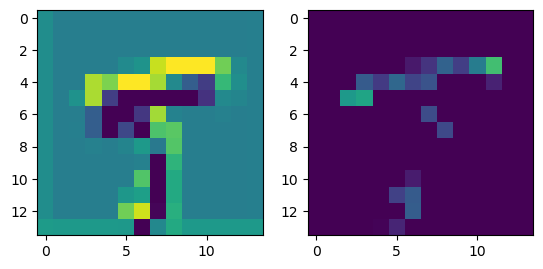

prediction: tensor([2, 9, 4]), tensor([2.2942, 1.2070, 0.9511]) groudtruth: 9
-0.02841604 0.02684516


<Figure size 640x480 with 0 Axes>

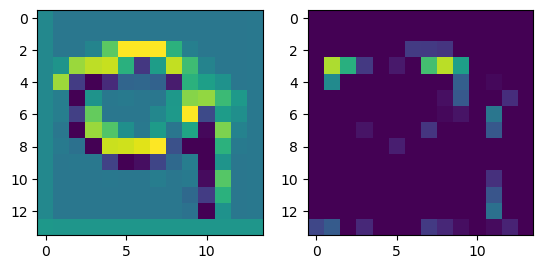

prediction: tensor([9, 7, 4]), tensor([1.4588, 0.9245, 0.7819]) groudtruth: 4
-0.02972931 0.020007811


<Figure size 640x480 with 0 Axes>

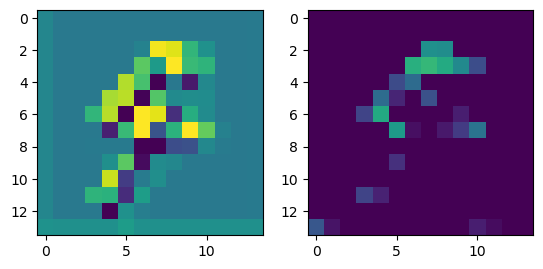

prediction: tensor([4, 5, 6]), tensor([2.4243, 1.8488, 1.1102]) groudtruth: 5
-0.0289197 0.022408947


<Figure size 640x480 with 0 Axes>

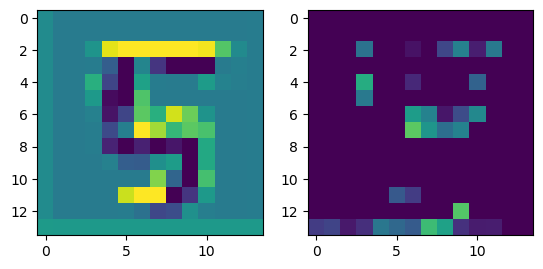

prediction: tensor([4, 9, 6]), tensor([4.8319, 2.7169, 1.4259]) groudtruth: 6
-0.03152848 0.027541313


<Figure size 640x480 with 0 Axes>

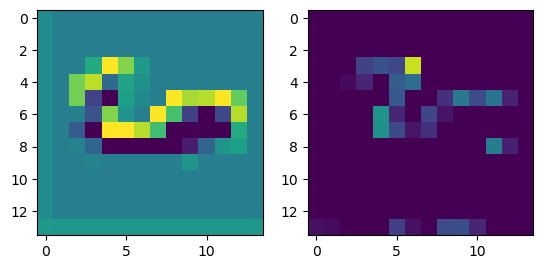

prediction: tensor([9, 4, 7]), tensor([2.5092, 2.1497, 1.4031]) groudtruth: 4
-0.03616876 0.03921039


<Figure size 640x480 with 0 Axes>

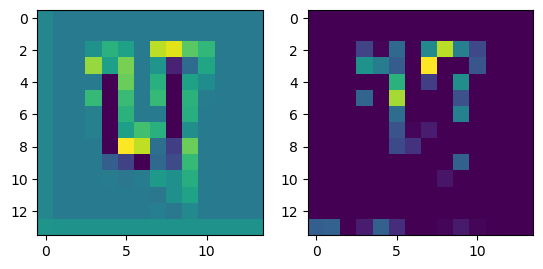

prediction: tensor([3, 5, 8]), tensor([3.0049, 1.4453, 1.4388]) groudtruth: 9
-0.025871223 0.01415471


<Figure size 640x480 with 0 Axes>

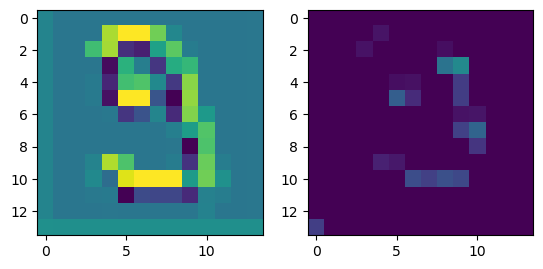

prediction: tensor([8, 5, 4]), tensor([1.9019, 1.3172, 1.2921]) groudtruth: 1
-0.034479514 0.038881615


<Figure size 640x480 with 0 Axes>

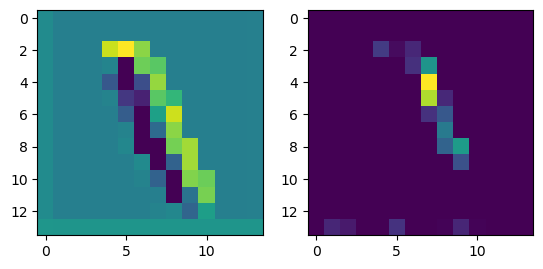

prediction: tensor([7, 2, 3]), tensor([2.0454, 1.9974, 1.6761]) groudtruth: 2
-0.024761228 0.02677675


<Figure size 640x480 with 0 Axes>

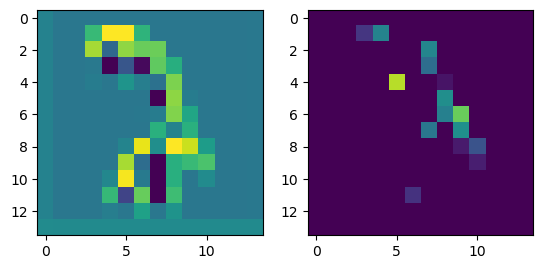

prediction: tensor([9, 4, 8]), tensor([2.8874, 2.5814, 1.5191]) groudtruth: 4
-0.019658728 0.020215183


<Figure size 640x480 with 0 Axes>

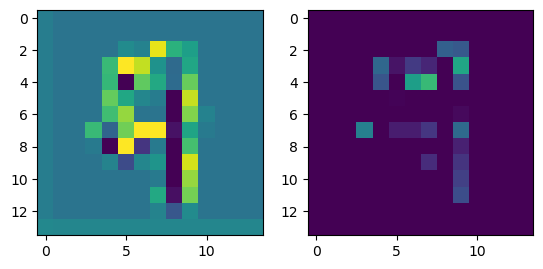

prediction: tensor([3, 5, 8]), tensor([1.2085, 0.8071, 0.7799]) groudtruth: 8
-0.030215545 0.026781026


<Figure size 640x480 with 0 Axes>

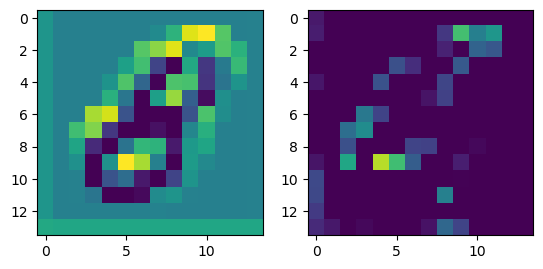

prediction: tensor([3, 8, 9]), tensor([3.0485, 2.2241, 1.3663]) groudtruth: 9
-0.02138171 0.01716853


<Figure size 640x480 with 0 Axes>

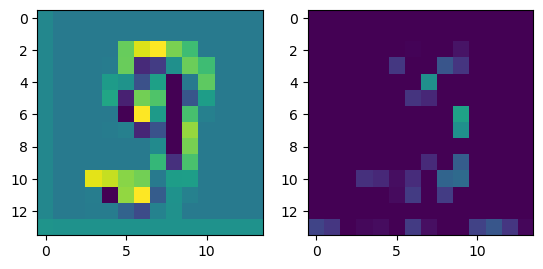

prediction: tensor([9, 7, 8]), tensor([2.9913, 2.2764, 1.7999]) groudtruth: 4
-0.033929475 0.016000923


<Figure size 640x480 with 0 Axes>

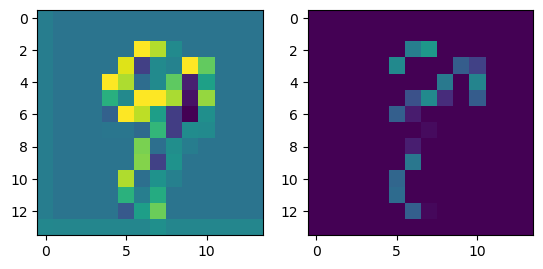

prediction: tensor([9, 4, 1]), tensor([2.5482, 1.7638, 1.0726]) groudtruth: 4
-0.027820589 0.027215466


<Figure size 640x480 with 0 Axes>

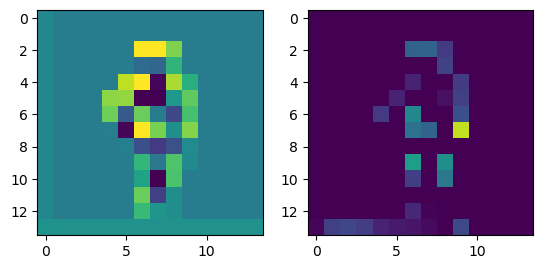

prediction: tensor([5, 0, 8]), tensor([1.4931, 1.2817, 1.2792]) groudtruth: 8
-0.03831981 0.0387357


<Figure size 640x480 with 0 Axes>

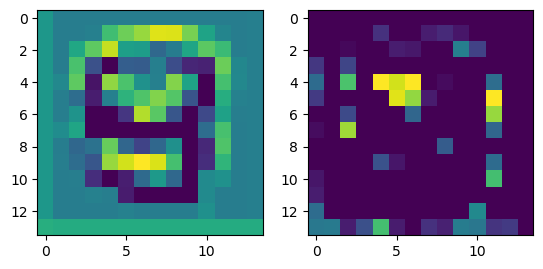

prediction: tensor([8, 5, 9]), tensor([2.6507, 1.9278, 0.0829]) groudtruth: 5
-0.030414792 0.027237222


<Figure size 640x480 with 0 Axes>

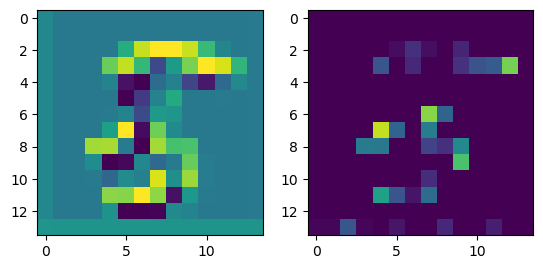

prediction: tensor([2, 5, 6]), tensor([2.2827, 2.2422, 1.2859]) groudtruth: 5
-0.03304151 0.027530517


<Figure size 640x480 with 0 Axes>

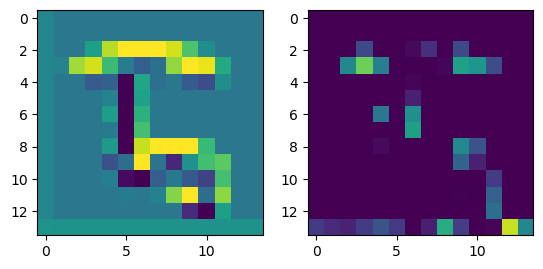

prediction: tensor([6, 2, 0]), tensor([3.7559, 2.4353, 1.0334]) groudtruth: 4
-0.039985552 0.023167647


<Figure size 640x480 with 0 Axes>

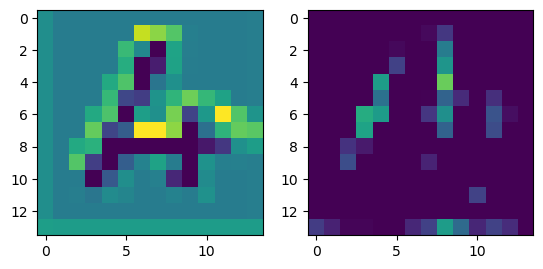

prediction: tensor([8, 2, 3]), tensor([2.1227, 2.0139, 1.4869]) groudtruth: 2
-0.032488164 0.02075633


<Figure size 640x480 with 0 Axes>

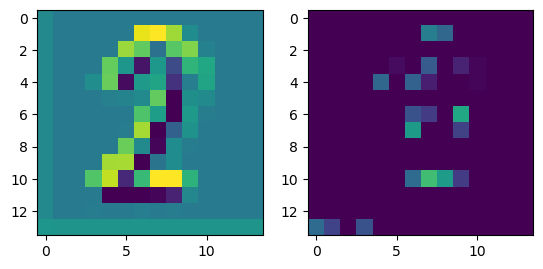

prediction: tensor([2, 5, 4]), tensor([1.1570, 1.0553, 1.0549]) groudtruth: 6
-0.024799531 0.018989058


<Figure size 640x480 with 0 Axes>

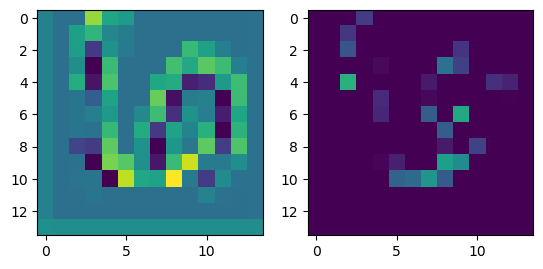

prediction: tensor([3, 8, 7]), tensor([1.9084, 1.3025, 0.7542]) groudtruth: 7
-0.030230701 0.028471446


<Figure size 640x480 with 0 Axes>

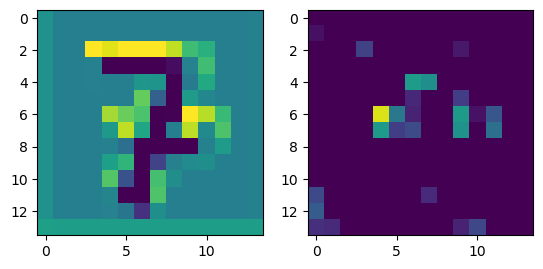

prediction: tensor([4, 9, 8]), tensor([4.0765, 3.5225, 1.0293]) groudtruth: 9
-0.025712134 0.022965997


<Figure size 640x480 with 0 Axes>

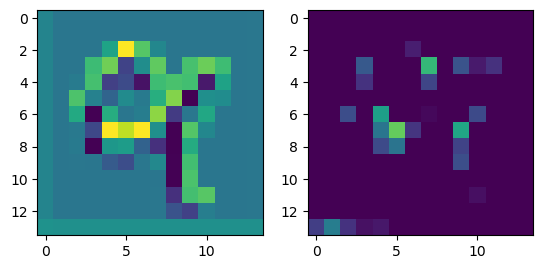

prediction: tensor([5, 0, 8]), tensor([3.2428, 1.3812, 1.1640]) groudtruth: 6
-0.021924261 0.014416549


<Figure size 640x480 with 0 Axes>

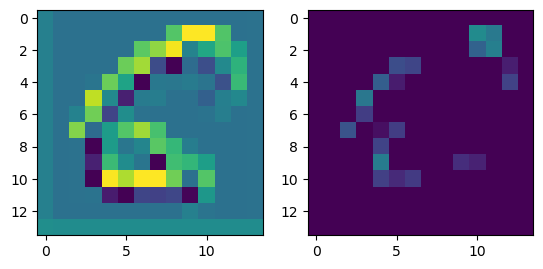

prediction: tensor([0, 8, 5]), tensor([2.5163, 1.6320, 0.4208]) groudtruth: 5
-0.03429366 0.025557443


<Figure size 640x480 with 0 Axes>

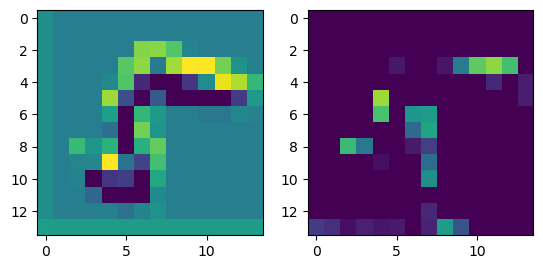

prediction: tensor([3, 2, 8]), tensor([3.9982, 1.7375, 1.4396]) groudtruth: 1
-0.026506681 0.020472087


<Figure size 640x480 with 0 Axes>

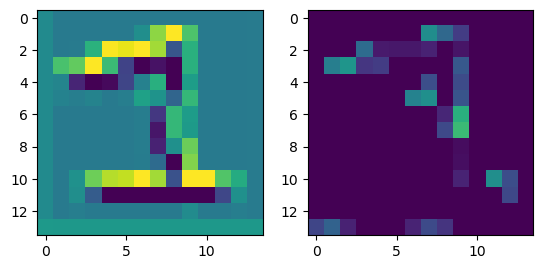

prediction: tensor([3, 5, 8]), tensor([3.2691, 2.3180, 0.9793]) groudtruth: 5
-0.037253067 0.022707954


<Figure size 640x480 with 0 Axes>

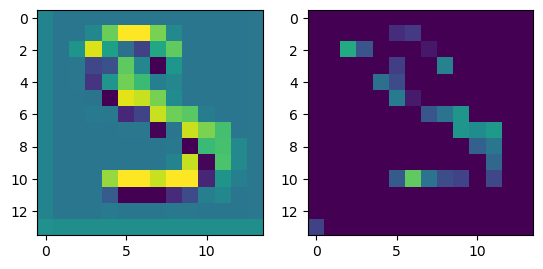

prediction: tensor([1, 6, 8]), tensor([2.1735, 1.9153, 1.1405]) groudtruth: 6
-0.019566793 0.01778718


<Figure size 640x480 with 0 Axes>

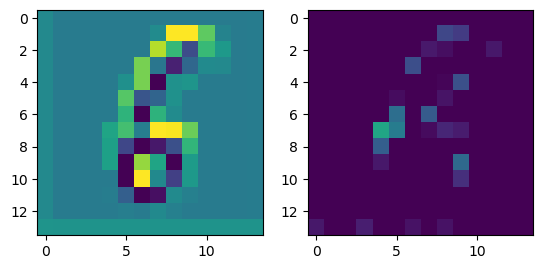

prediction: tensor([0, 3, 5]), tensor([2.6463, 2.4353, 2.1926]) groudtruth: 3
-0.03519238 0.037739


<Figure size 640x480 with 0 Axes>

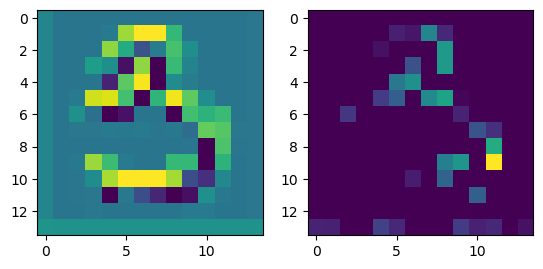

prediction: tensor([2, 4, 9]), tensor([3.4339, 1.4102, 1.0582]) groudtruth: 9
-0.03031094 0.028863588


<Figure size 640x480 with 0 Axes>

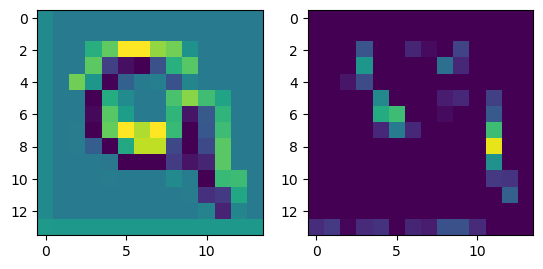

prediction: tensor([5, 4, 0]), tensor([2.2229, 1.7595, 1.5618]) groudtruth: 9
-0.025290191 0.020720635


<Figure size 640x480 with 0 Axes>

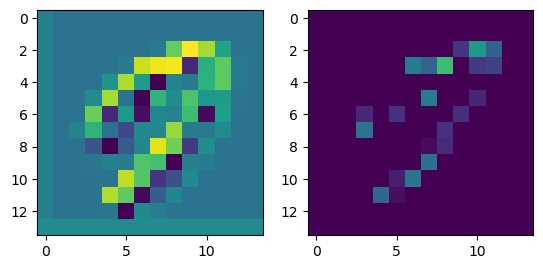

prediction: tensor([7, 9, 8]), tensor([3.7742, 3.1874, 0.6729]) groudtruth: 9
-0.031883474 0.030076385


<Figure size 640x480 with 0 Axes>

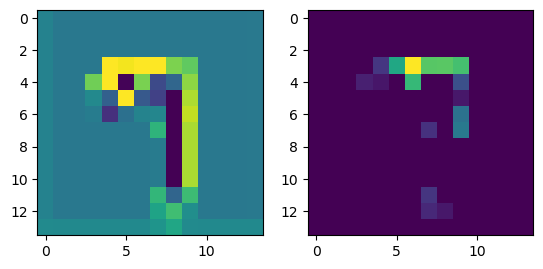

prediction: tensor([0, 8, 5]), tensor([1.9556, 1.7011, 1.2997]) groudtruth: 8
-0.032688722 0.037607178


<Figure size 640x480 with 0 Axes>

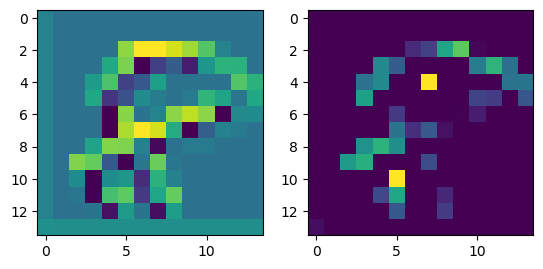

prediction: tensor([3, 9, 7]), tensor([1.2859, 1.2767, 1.1595]) groudtruth: 7
-0.03242694 0.025985565


<Figure size 640x480 with 0 Axes>

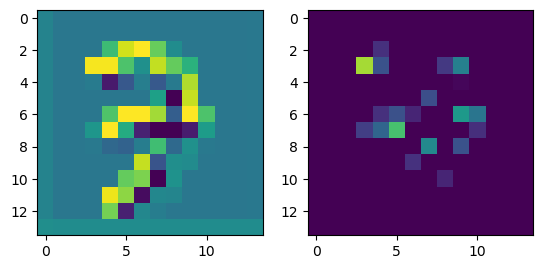

prediction: tensor([7, 9, 0]), tensor([3.7331, 1.4997, 0.3154]) groudtruth: 2
-0.025985885 0.01841443


<Figure size 640x480 with 0 Axes>

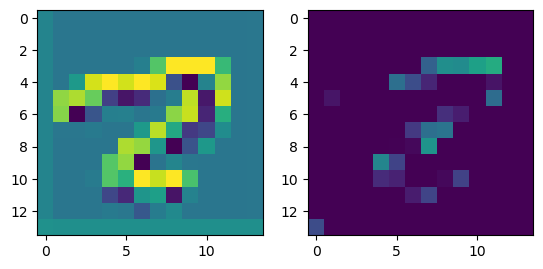

prediction: tensor([8, 1, 7]), tensor([2.2274, 2.1629, 1.1987]) groudtruth: 7
-0.025458284 0.026117692


<Figure size 640x480 with 0 Axes>

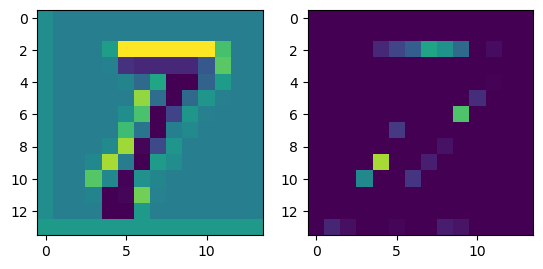

prediction: tensor([8, 9, 7]), tensor([1.1044, 1.0094, 0.6595]) groudtruth: 5
-0.03236723 0.025854206


<Figure size 640x480 with 0 Axes>

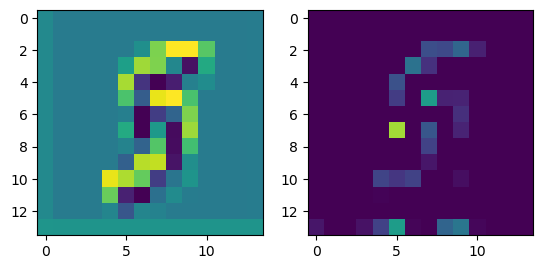

prediction: tensor([1, 8, 5]), tensor([1.6717, 0.9008, 0.2238]) groudtruth: 5
-0.026377808 0.029405642


<Figure size 640x480 with 0 Axes>

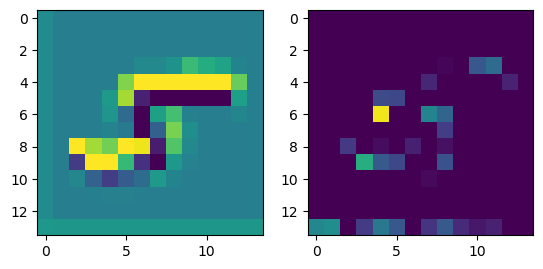

prediction: tensor([9, 5, 3]), tensor([2.2652, 2.0351, 1.2061]) groudtruth: 5
-0.028884728 0.02925178


<Figure size 640x480 with 0 Axes>

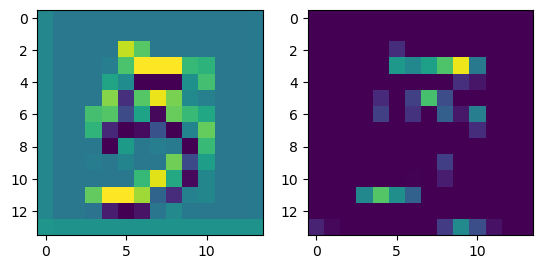

prediction: tensor([8, 5, 3]), tensor([1.3337, 1.1704, 0.8031]) groudtruth: 5
-0.022343358 0.015976222


<Figure size 640x480 with 0 Axes>

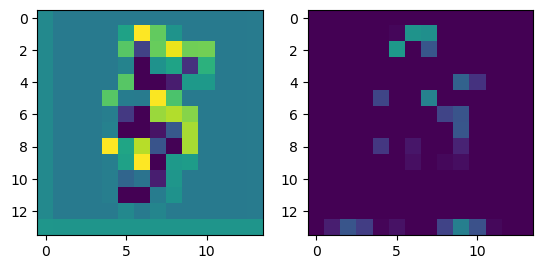

prediction: tensor([7, 9, 3]), tensor([2.2872, 2.2704, 1.2680]) groudtruth: 9
-0.024048109 0.022919793


<Figure size 640x480 with 0 Axes>

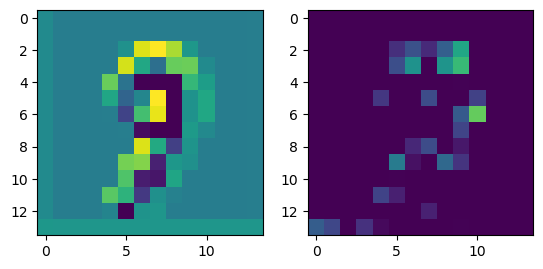

prediction: tensor([3, 5, 8]), tensor([2.1863, 2.0427, 1.7445]) groudtruth: 5
-0.036951825 0.021120515


<Figure size 640x480 with 0 Axes>

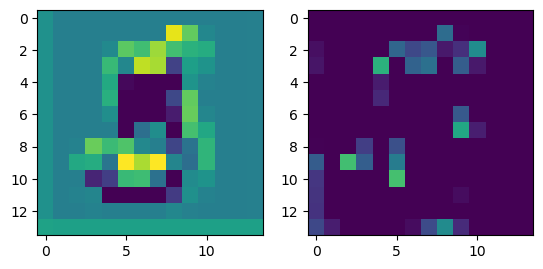

prediction: tensor([9, 8, 7]), tensor([1.3809, 1.0611, 0.5473]) groudtruth: 7
-0.024812017 0.024353437


<Figure size 640x480 with 0 Axes>

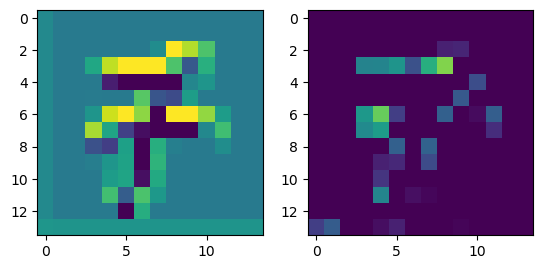

prediction: tensor([8, 3, 2]), tensor([2.4102, 1.6507, 1.0436]) groudtruth: 2
-0.035621874 0.021527112


<Figure size 640x480 with 0 Axes>

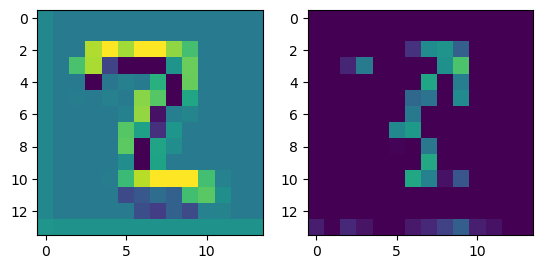

prediction: tensor([9, 4, 1]), tensor([3.1356, 2.9532, 1.2119]) groudtruth: 4
-0.030772869 0.019213142


<Figure size 640x480 with 0 Axes>

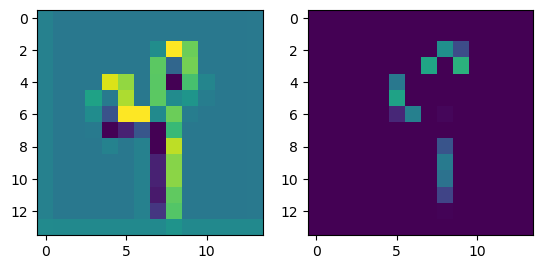

prediction: tensor([6, 0, 5]), tensor([2.5047, 2.1348, 1.7583]) groudtruth: 5
-0.036177777 0.02727735


<Figure size 640x480 with 0 Axes>

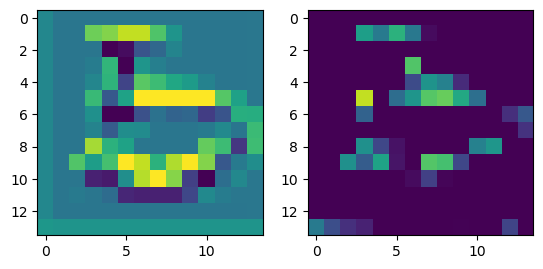

prediction: tensor([4, 9, 7]), tensor([3.6390, 2.9842, 2.5463]) groudtruth: 7
-0.02828936 0.027755402


<Figure size 640x480 with 0 Axes>

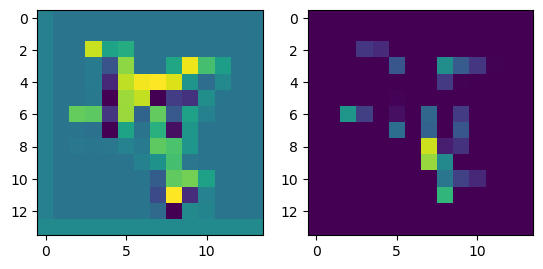

prediction: tensor([4, 2, 9]), tensor([2.6624, 0.8325, 0.7854]) groudtruth: 2
-0.024526581 0.030692253


<Figure size 640x480 with 0 Axes>

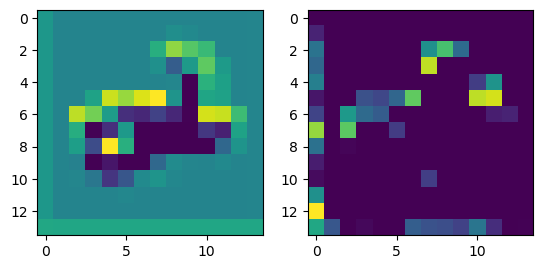

prediction: tensor([4, 9, 8]), tensor([2.6199, 2.2071, 0.2097]) groudtruth: 9
-0.021185022 0.026382068


<Figure size 640x480 with 0 Axes>

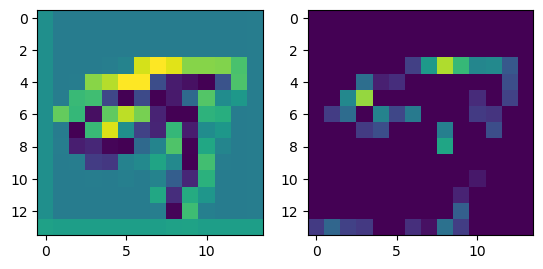

prediction: tensor([6, 4, 9]), tensor([1.9182, 1.8723, 1.4782]) groudtruth: 4
-0.022632705 0.021650597


<Figure size 640x480 with 0 Axes>

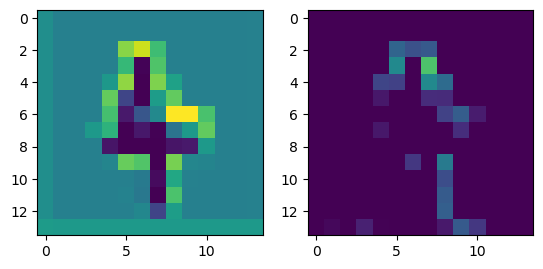

prediction: tensor([6, 8, 5]), tensor([2.2997, 0.7635, 0.5742]) groudtruth: 8
-0.027825277 0.025251888


<Figure size 640x480 with 0 Axes>

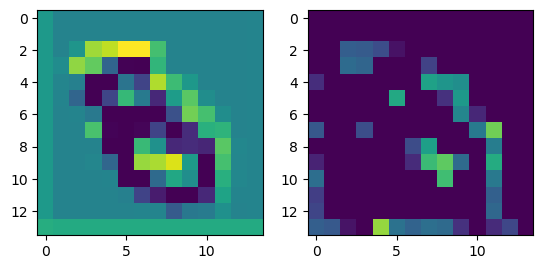

prediction: tensor([9, 4, 8]), tensor([2.4522, 2.3069, 0.5304]) groudtruth: 4
-0.025386557 0.021253927


<Figure size 640x480 with 0 Axes>

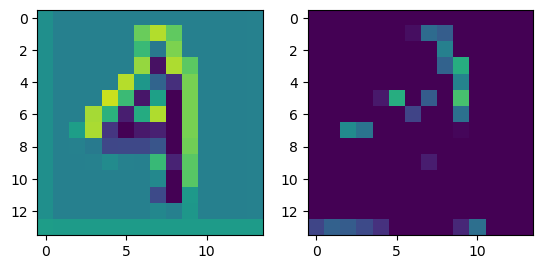

prediction: tensor([6, 9, 1]), tensor([2.2546, 1.0423, 0.4302]) groudtruth: 4
-0.019380432 0.026507458


<Figure size 640x480 with 0 Axes>

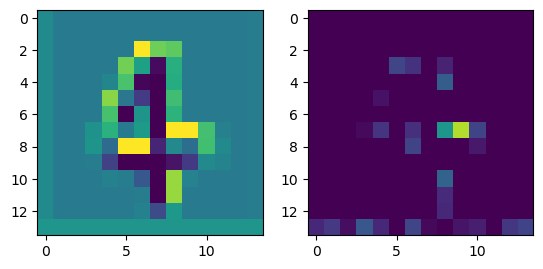

prediction: tensor([3, 5, 0]), tensor([2.3172, 1.8945, 1.8248]) groudtruth: 8
-0.03273549 0.03748651


<Figure size 640x480 with 0 Axes>

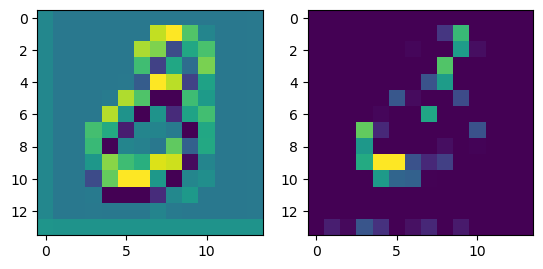

prediction: tensor([9, 4, 8]), tensor([2.8237, 2.8130, 1.4326]) groudtruth: 4
-0.03541609 0.028301762


<Figure size 640x480 with 0 Axes>

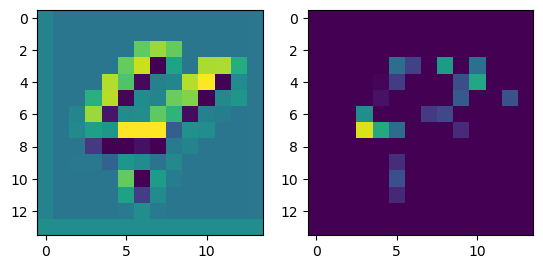

prediction: tensor([7, 0, 3]), tensor([1.3348, 1.0182, 0.7719]) groudtruth: 6
-0.027553149 0.01666696


<Figure size 640x480 with 0 Axes>

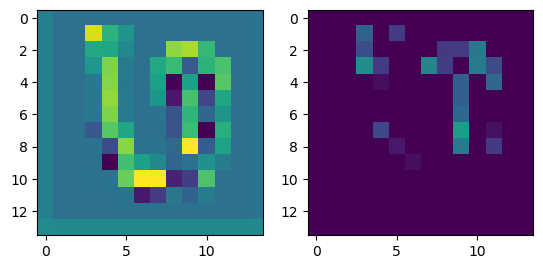

prediction: tensor([9, 4, 7]), tensor([3.2011, 2.9973, 0.7436]) groudtruth: 4
-0.0361113 0.033452414


<Figure size 640x480 with 0 Axes>

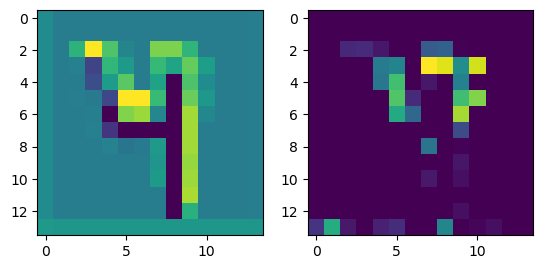

prediction: tensor([0, 2, 9]), tensor([2.1005, 1.8183, 1.2093]) groudtruth: 9
-0.024775151 0.031875998


<Figure size 640x480 with 0 Axes>

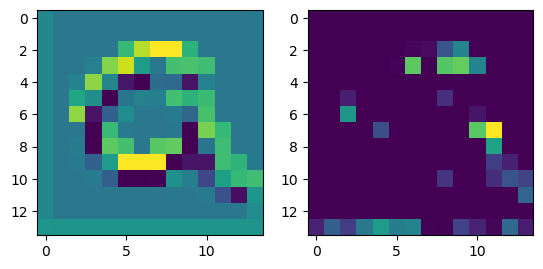

prediction: tensor([6, 5, 4]), tensor([1.9222, 1.0607, 0.9401]) groudtruth: 2
-0.033173494 0.031830154


<Figure size 640x480 with 0 Axes>

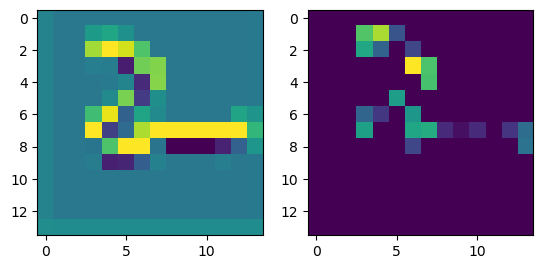

prediction: tensor([6, 8, 9]), tensor([1.5251, 1.3707, 1.2808]) groudtruth: 8
-0.036852587 0.025906453


<Figure size 640x480 with 0 Axes>

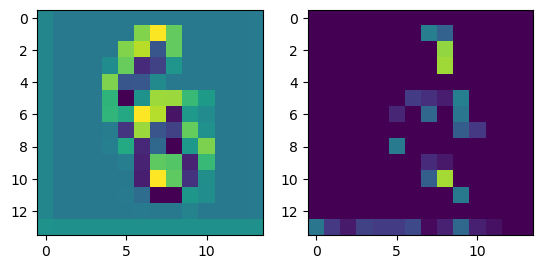

prediction: tensor([3, 7, 2]), tensor([2.3891, 2.0413, 1.7745]) groudtruth: 2
-0.039546166 0.031740513


<Figure size 640x480 with 0 Axes>

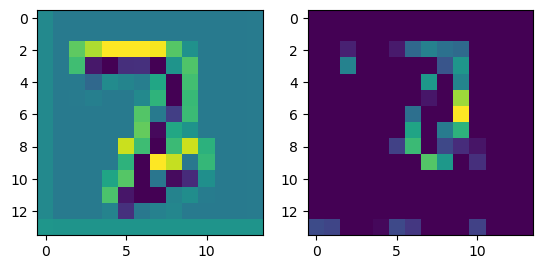

prediction: tensor([7, 6, 8]), tensor([1.5987, 1.4844, 1.2187]) groudtruth: 2
-0.036141146 0.039557647


<Figure size 640x480 with 0 Axes>

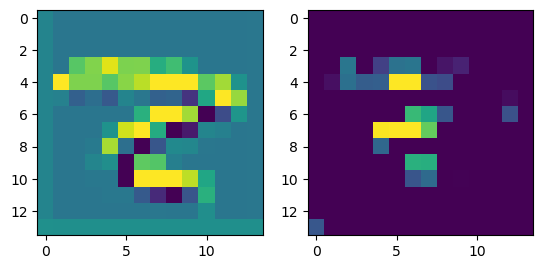

prediction: tensor([9, 4, 1]), tensor([3.1503, 2.8016, 1.1129]) groudtruth: 4
-0.031176433 0.022861518


<Figure size 640x480 with 0 Axes>

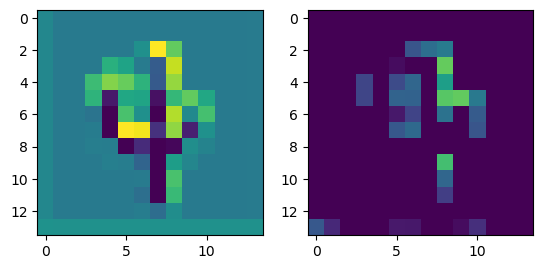

prediction: tensor([1, 8, 2]), tensor([1.8216, 1.7175, 1.3460]) groudtruth: 8
-0.028624319 0.02366036


<Figure size 640x480 with 0 Axes>

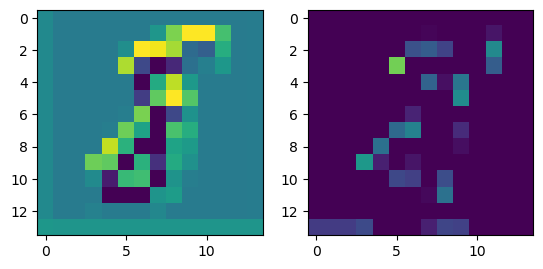

prediction: tensor([2, 8, 3]), tensor([2.2158, 0.8780, 0.5536]) groudtruth: 3
-0.02544028 0.020442624


<Figure size 640x480 with 0 Axes>

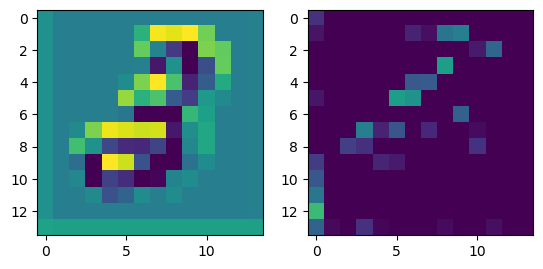

prediction: tensor([1, 7, 3]), tensor([1.8820, 1.1473, 1.0645]) groudtruth: 4
-0.026276158 0.019825121


<Figure size 640x480 with 0 Axes>

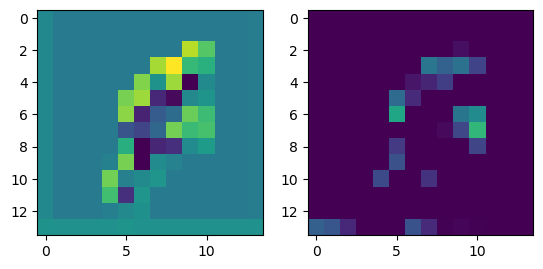

prediction: tensor([6, 5, 8]), tensor([1.6074, 1.0561, 0.9188]) groudtruth: 5
-0.03354214 0.041776106


<Figure size 640x480 with 0 Axes>

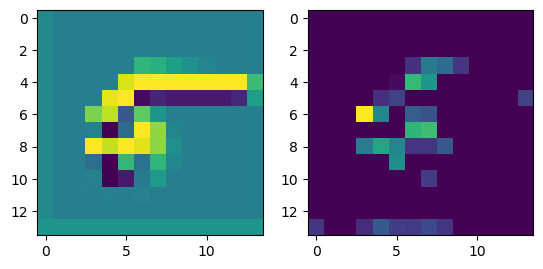

prediction: tensor([9, 8, 7]), tensor([2.5427, 2.0436, 1.4331]) groudtruth: 8
-0.032549683 0.03188241


<Figure size 640x480 with 0 Axes>

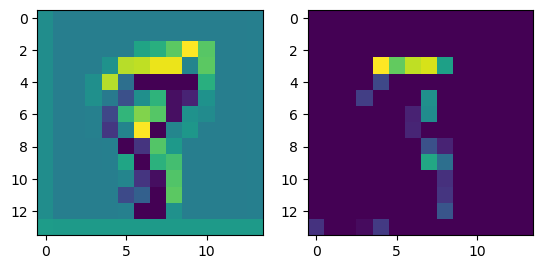

prediction: tensor([3, 5, 8]), tensor([2.7441, 2.4385, 1.1855]) groudtruth: 5
-0.03183878 0.031813912


<Figure size 640x480 with 0 Axes>

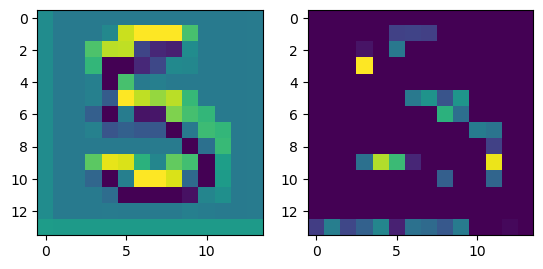

prediction: tensor([9, 6, 4]), tensor([1.7892, 1.5610, 1.2114]) groudtruth: 4
-0.02029382 0.022671562


<Figure size 640x480 with 0 Axes>

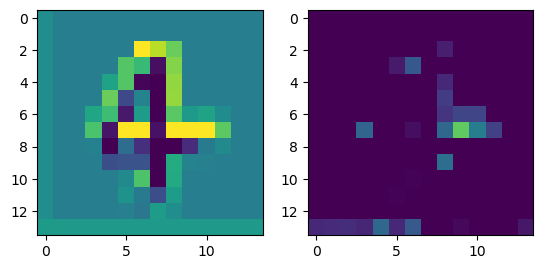

prediction: tensor([8, 1, 0]), tensor([2.3589, 0.8692, 0.6751]) groudtruth: 1
-0.027398538 0.033903956


<Figure size 640x480 with 0 Axes>

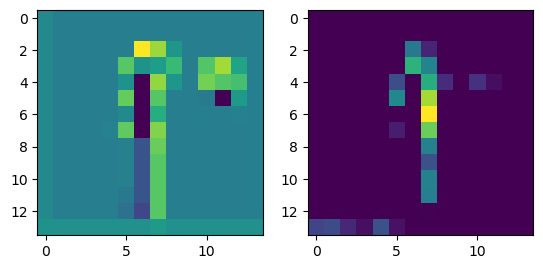

prediction: tensor([4, 8, 5]), tensor([1.9810, 1.8023, 1.4131]) groudtruth: 8
-0.032368228 0.031719126


<Figure size 640x480 with 0 Axes>

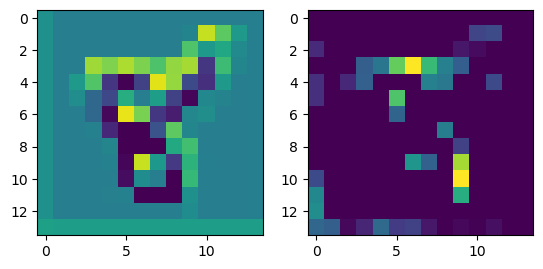

prediction: tensor([4, 8, 5]), tensor([2.5377, 1.5641, 1.1465]) groudtruth: 8
-0.03241517 0.036038958


<Figure size 640x480 with 0 Axes>

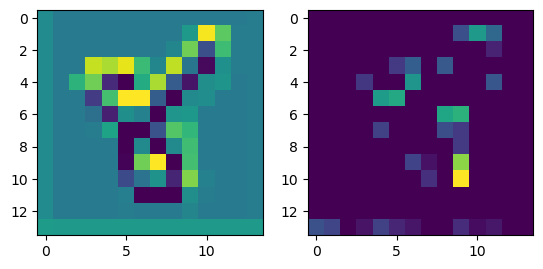

prediction: tensor([9, 7, 8]), tensor([3.4541, 2.9519, 1.6139]) groudtruth: 7
-0.03168099 0.016963948


<Figure size 640x480 with 0 Axes>

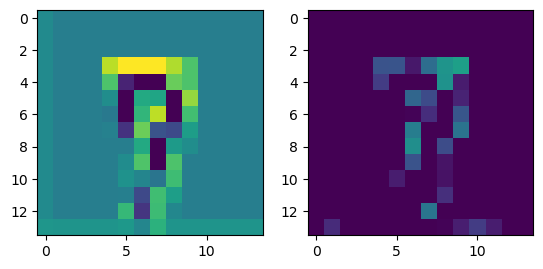

prediction: tensor([6, 8, 5]), tensor([1.4143, 1.3957, 1.2887]) groudtruth: 5
-0.029060604 0.02535717


<Figure size 640x480 with 0 Axes>

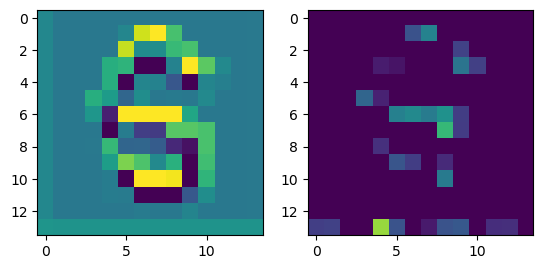

prediction: tensor([9, 7, 8]), tensor([2.1245, 1.7752, 1.2381]) groudtruth: 7
-0.03197793 0.021591421


<Figure size 640x480 with 0 Axes>

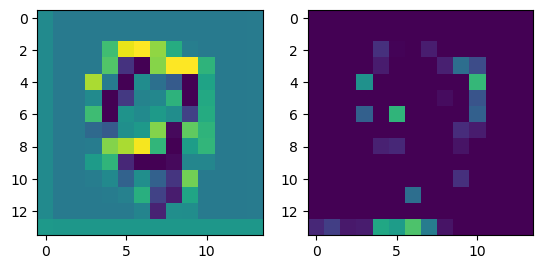

prediction: tensor([0, 6, 2]), tensor([2.2641, 2.0395, 0.9641]) groudtruth: 4
-0.029600872 0.02813277


<Figure size 640x480 with 0 Axes>

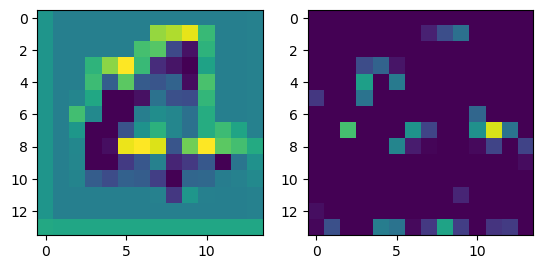

prediction: tensor([8, 3, 0]), tensor([1.3588, 1.0182, 0.8210]) groudtruth: 0
-0.026806805 0.024457954


<Figure size 640x480 with 0 Axes>

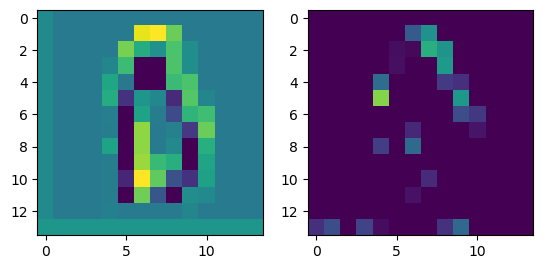

prediction: tensor([0, 6, 3]), tensor([2.5804, 2.3737, 2.1843]) groudtruth: 5
-0.03557976 0.030533496


<Figure size 640x480 with 0 Axes>

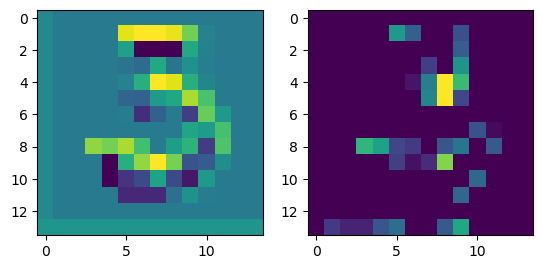

prediction: tensor([9, 7, 4]), tensor([3.6357, 2.9620, 1.3176]) groudtruth: 7
-0.030270655 0.022112561


<Figure size 640x480 with 0 Axes>

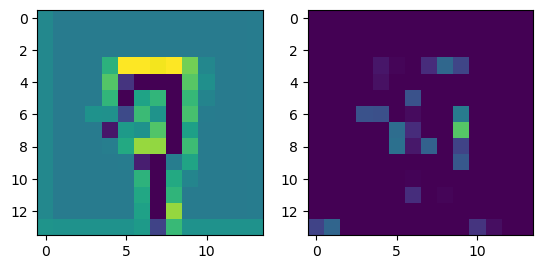

prediction: tensor([9, 8, 6]), tensor([1.4982, 1.4440, 0.4263]) groudtruth: 3
-0.03216408 0.01896292


<Figure size 640x480 with 0 Axes>

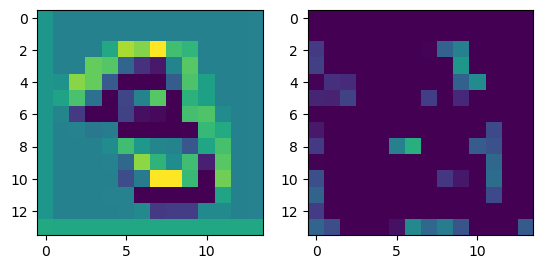

prediction: tensor([3, 8, 5]), tensor([2.3315, 2.1063, 2.0907]) groudtruth: 5
-0.041657895 0.035449773


<Figure size 640x480 with 0 Axes>

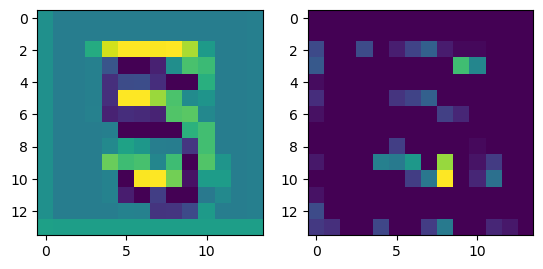

prediction: tensor([3, 5, 8]), tensor([2.5882, 1.8473, 1.5019]) groudtruth: 5
-0.03246182 0.0421148


<Figure size 640x480 with 0 Axes>

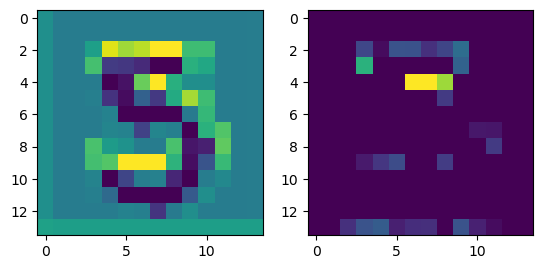

prediction: tensor([9, 4, 5]), tensor([2.4049, 2.0120, 1.5722]) groudtruth: 4
-0.032522604 0.020730482


<Figure size 640x480 with 0 Axes>

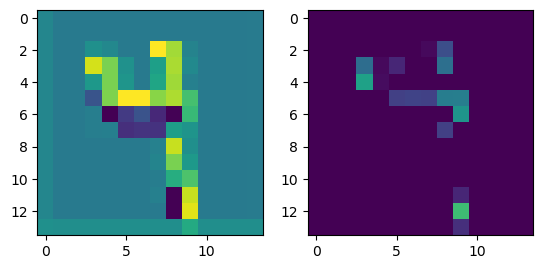

prediction: tensor([9, 8, 7]), tensor([2.0345, 1.9171, 0.9162]) groudtruth: 8
-0.040352687 0.02858036


<Figure size 640x480 with 0 Axes>

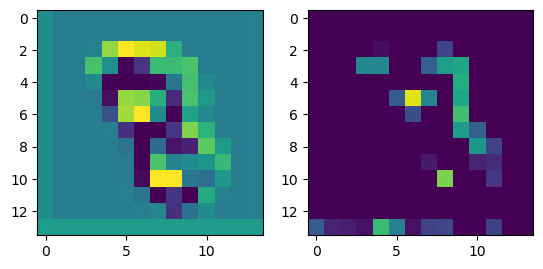

prediction: tensor([3, 5, 8]), tensor([2.6965, 2.5180, 1.2390]) groudtruth: 5
-0.041113403 0.022784013


<Figure size 640x480 with 0 Axes>

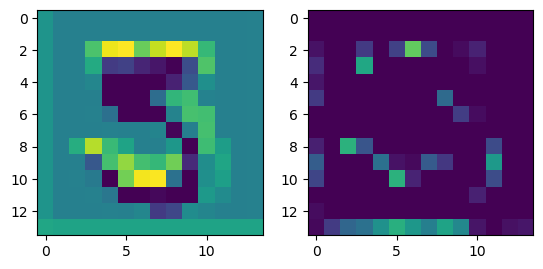

prediction: tensor([0, 5, 8]), tensor([2.0694, 2.0230, 1.1076]) groudtruth: 9
-0.037140183 0.023364086


<Figure size 640x480 with 0 Axes>

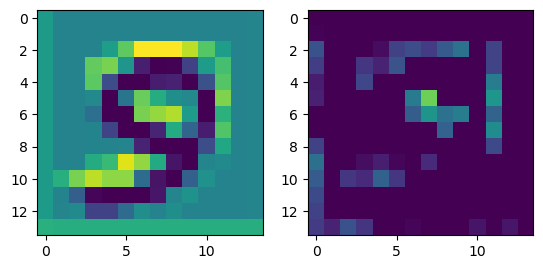

prediction: tensor([6, 5, 9]), tensor([2.2000, 0.4968, 0.4487]) groudtruth: 5
-0.03830983 0.03780353


<Figure size 640x480 with 0 Axes>

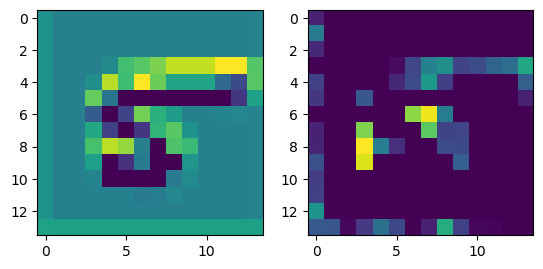

prediction: tensor([0, 5, 8]), tensor([2.3517, 1.9582, 0.8728]) groudtruth: 9
-0.02334003 0.021332221


<Figure size 640x480 with 0 Axes>

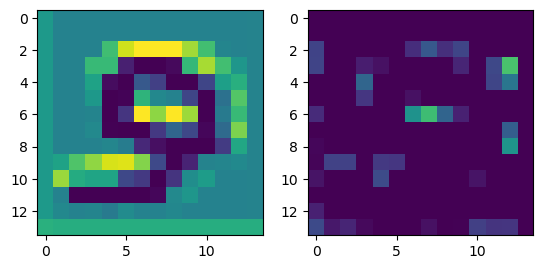

prediction: tensor([8, 2, 3]), tensor([2.0447, 1.5257, 1.1415]) groudtruth: 2
-0.036930703 0.03473996


<Figure size 640x480 with 0 Axes>

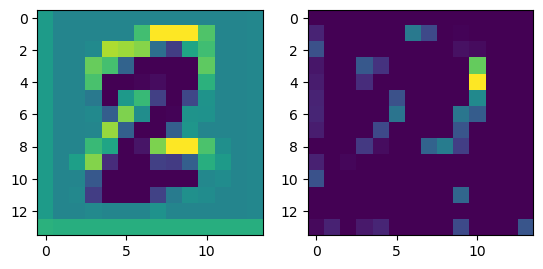

prediction: tensor([0, 6, 5]), tensor([2.0991, 0.8716, 0.8692]) groudtruth: 9
-0.035542622 0.028288573


<Figure size 640x480 with 0 Axes>

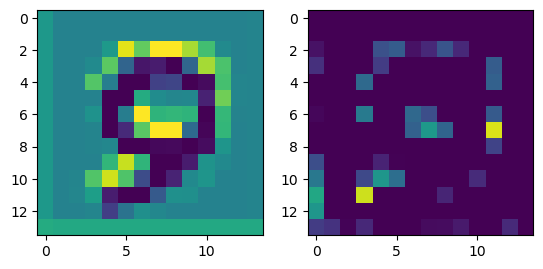

prediction: tensor([6, 8, 2]), tensor([2.2837, 1.0551, 0.6026]) groudtruth: 8
-0.032679204 0.025948748


<Figure size 640x480 with 0 Axes>

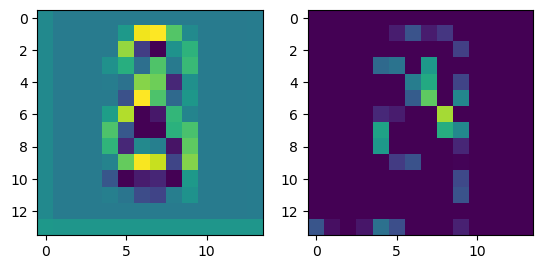

prediction: tensor([6, 0, 8]), tensor([2.1468, 1.9170, 0.4409]) groudtruth: 0
-0.02743634 0.021599188


<Figure size 640x480 with 0 Axes>

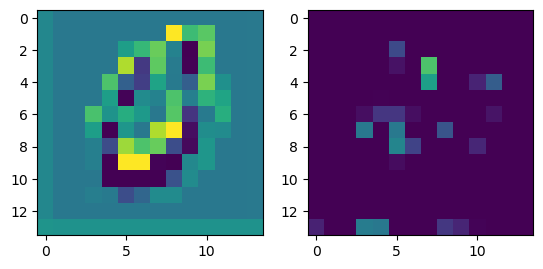

prediction: tensor([7, 0, 9]), tensor([3.0229, 2.3629, 1.0908]) groudtruth: 0
-0.047375824 0.022152271


<Figure size 640x480 with 0 Axes>

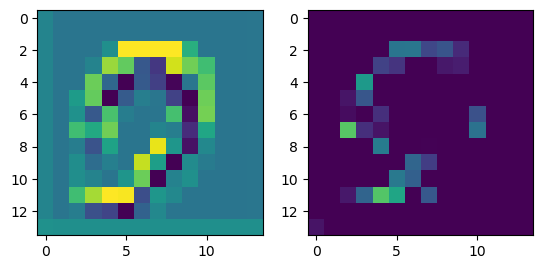

prediction: tensor([6, 2, 0]), tensor([1.9554, 1.5110, 0.4213]) groudtruth: 5
-0.0338608 0.026466781


<Figure size 640x480 with 0 Axes>

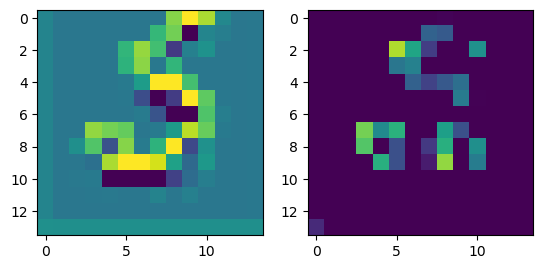

prediction: tensor([7, 9, 8]), tensor([2.3016, 2.0978, 1.5031]) groudtruth: 8
-0.04665532 0.036930155


<Figure size 640x480 with 0 Axes>

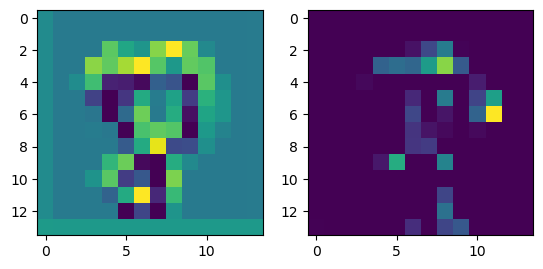

prediction: tensor([8, 1, 4]), tensor([1.9329, 1.5698, 0.5541]) groudtruth: 1
-0.023929633 0.017167725


<Figure size 640x480 with 0 Axes>

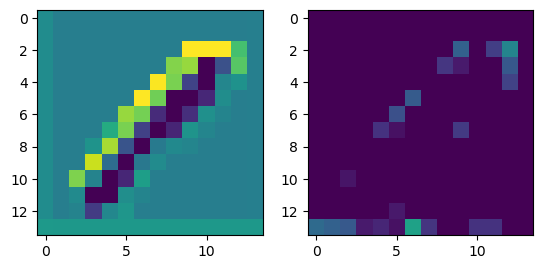

prediction: tensor([0, 5, 3]), tensor([1.6669, 1.6001, 0.9785]) groudtruth: 3
-0.027499134 0.03174969


<Figure size 640x480 with 0 Axes>

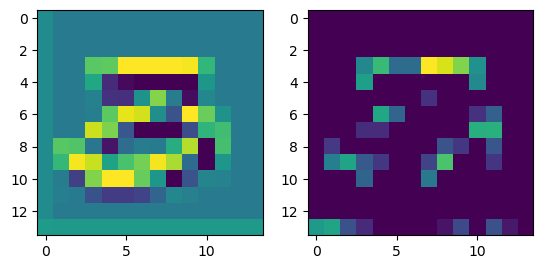

prediction: tensor([5, 6, 0]), tensor([2.7943, 2.1332, 2.1060]) groudtruth: 6
-0.030968469 0.027935252


<Figure size 640x480 with 0 Axes>

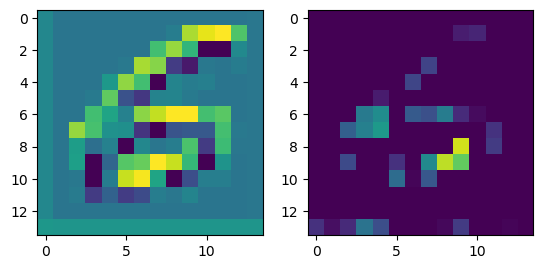

prediction: tensor([4, 6, 9]), tensor([1.8408, 1.2719, 1.0585]) groudtruth: 2
-0.036310084 0.04197643


<Figure size 640x480 with 0 Axes>

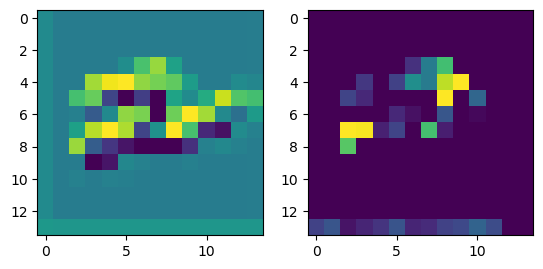

prediction: tensor([4, 9, 6]), tensor([2.6750, 2.0003, 0.7144]) groudtruth: 9
-0.037035037 0.027036462


<Figure size 640x480 with 0 Axes>

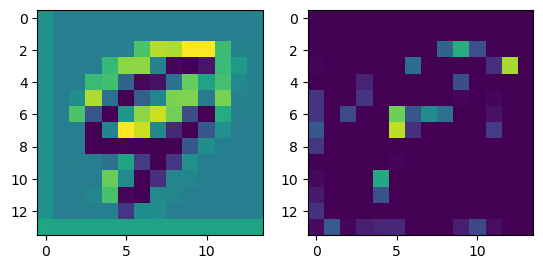

prediction: tensor([4, 6, 5]), tensor([3.1935, 2.4350, 0.8719]) groudtruth: 2
-0.031988043 0.02943089


<Figure size 640x480 with 0 Axes>

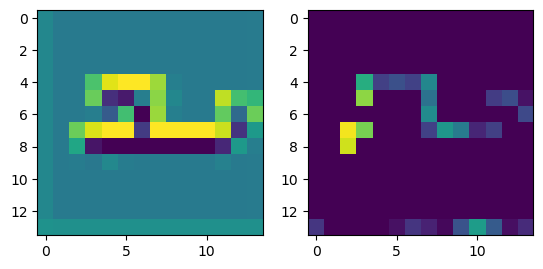

prediction: tensor([2, 3, 7]), tensor([2.1126, 1.6060, 0.8369]) groudtruth: 3
-0.031174082 0.026239483


<Figure size 640x480 with 0 Axes>

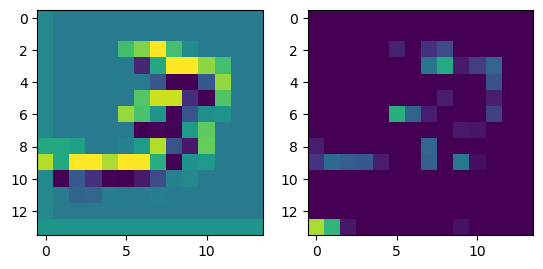

prediction: tensor([8, 4, 9]), tensor([1.3501, 1.2071, 1.1819]) groudtruth: 9
-0.022593785 0.021348197


<Figure size 640x480 with 0 Axes>

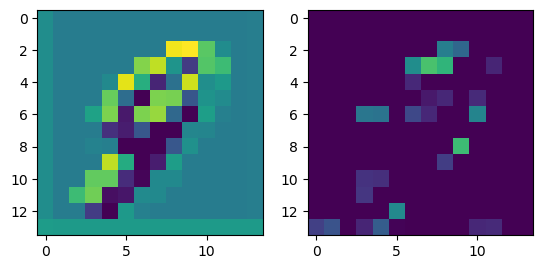

prediction: tensor([6, 7, 2]), tensor([1.1310, 1.0946, 0.9632]) groudtruth: 2
-0.040636394 0.03832294


<Figure size 640x480 with 0 Axes>

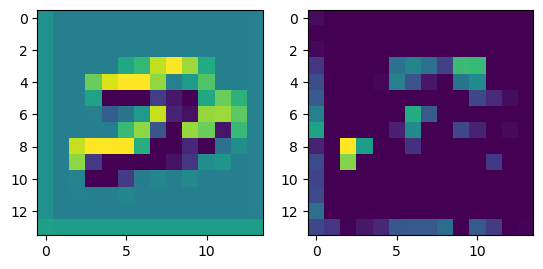

prediction: tensor([9, 4, 6]), tensor([2.6007, 2.3537, 0.8755]) groudtruth: 4
-0.030717257 0.030883951


<Figure size 640x480 with 0 Axes>

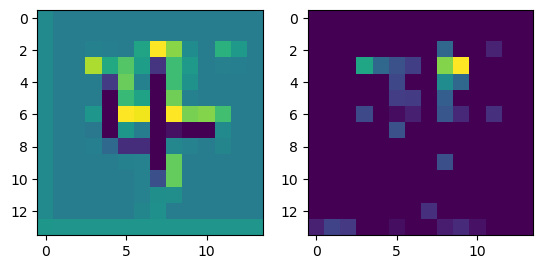

prediction: tensor([6, 2, 5]), tensor([1.3060, 1.0034, 0.8396]) groudtruth: 2
-0.03988035 0.028700992


<Figure size 640x480 with 0 Axes>

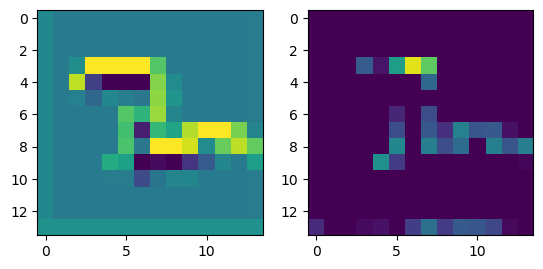

prediction: tensor([7, 9, 8]), tensor([2.6280, 2.3544, 1.6376]) groudtruth: 9
-0.031042214 0.021015005


<Figure size 640x480 with 0 Axes>

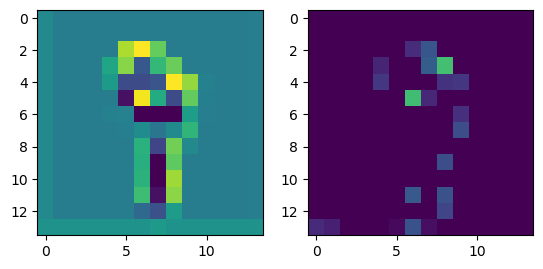

prediction: tensor([9, 4, 7]), tensor([2.9884, 2.9497, 0.7793]) groudtruth: 4
-0.028178096 0.024667837


<Figure size 640x480 with 0 Axes>

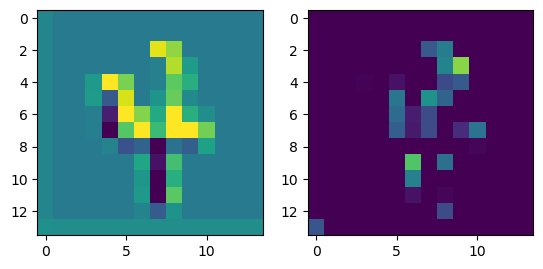

prediction: tensor([8, 9, 4]), tensor([1.9619, 1.8530, 1.8351]) groudtruth: 4
-0.019285992 0.020042408


<Figure size 640x480 with 0 Axes>

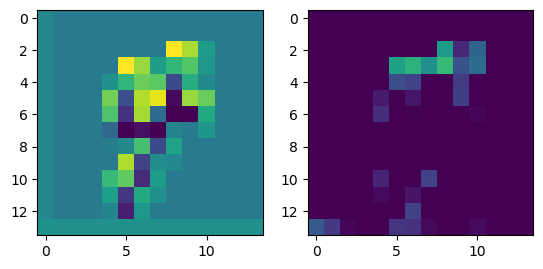

prediction: tensor([9, 4, 7]), tensor([2.8103, 2.6746, 0.9810]) groudtruth: 4
-0.029033452 0.02582759


<Figure size 640x480 with 0 Axes>

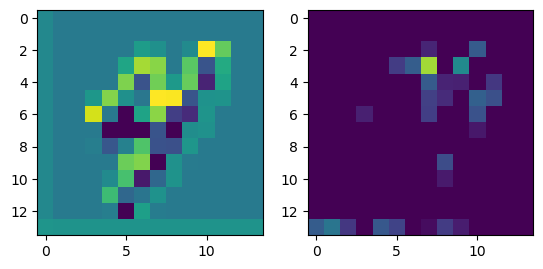

prediction: tensor([6, 0, 4]), tensor([2.1128, 1.1971, 0.6163]) groudtruth: 0
-0.027938971 0.021808218


<Figure size 640x480 with 0 Axes>

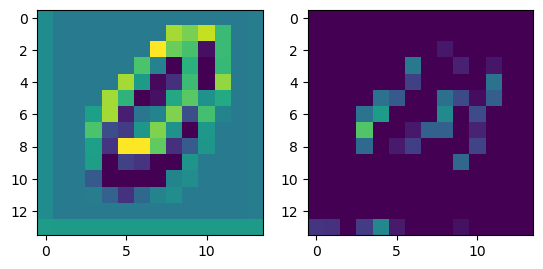

prediction: tensor([7, 8, 3]), tensor([2.5160, 2.2777, 2.1703]) groudtruth: 3
-0.04488986 0.018953258


<Figure size 640x480 with 0 Axes>

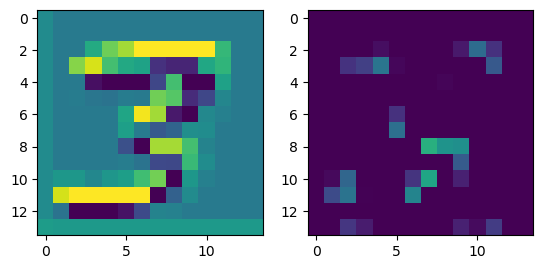

prediction: tensor([7, 0, 5]), tensor([2.0070, 1.9462, 1.7491]) groudtruth: 3
-0.025094409 0.0209262


<Figure size 640x480 with 0 Axes>

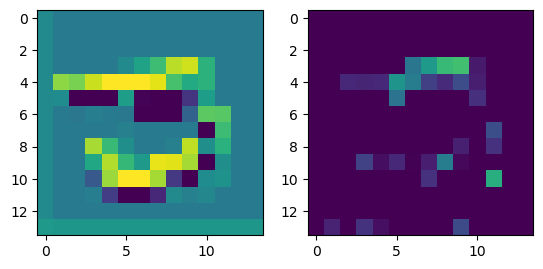

prediction: tensor([3, 5, 8]), tensor([2.7884, 1.8755, 0.7037]) groudtruth: 5
-0.031246832 0.022173349


<Figure size 640x480 with 0 Axes>

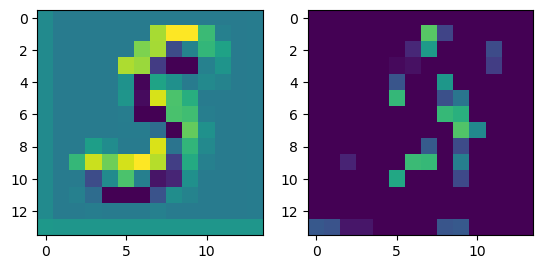

prediction: tensor([9, 8, 4]), tensor([2.2354, 1.8807, 1.6762]) groudtruth: 4
-0.029091554 0.019081952


<Figure size 640x480 with 0 Axes>

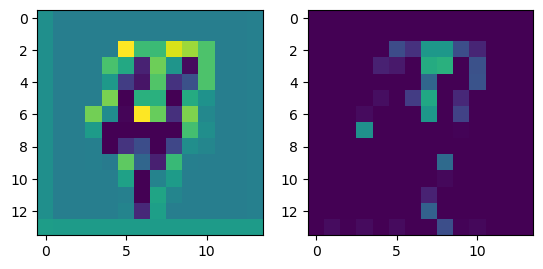

prediction: tensor([3, 5, 2]), tensor([2.3105, 2.2908, 0.4821]) groudtruth: 5
-0.03406873 0.02316044


<Figure size 640x480 with 0 Axes>

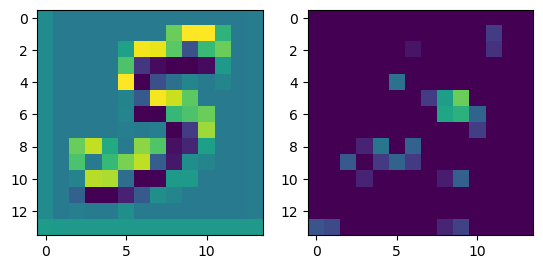

prediction: tensor([2, 8, 1]), tensor([2.6724, 1.7496, 0.7589]) groudtruth: 7
-0.025299136 0.01864595


<Figure size 640x480 with 0 Axes>

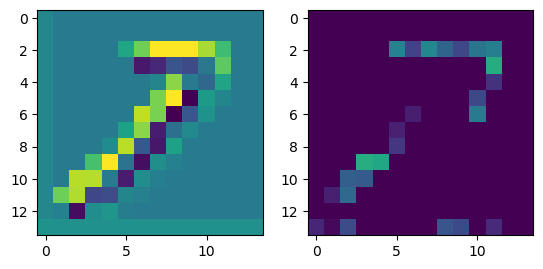

prediction: tensor([2, 8, 1]), tensor([1.8769, 1.4769, 1.0499]) groudtruth: 8
-0.027633136 0.031136287


<Figure size 640x480 with 0 Axes>

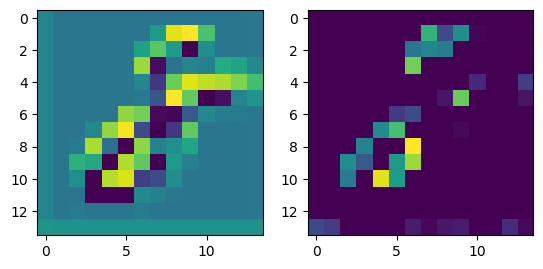

prediction: tensor([8, 5, 9]), tensor([2.0478, 0.7338, 0.3578]) groudtruth: 4
-0.03535281 0.02500993


<Figure size 640x480 with 0 Axes>

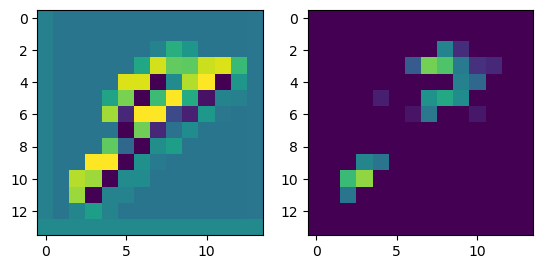

prediction: tensor([8, 3, 9]), tensor([2.3813, 1.5514, 0.4021]) groudtruth: 3
-0.03057672 0.029648958


<Figure size 640x480 with 0 Axes>

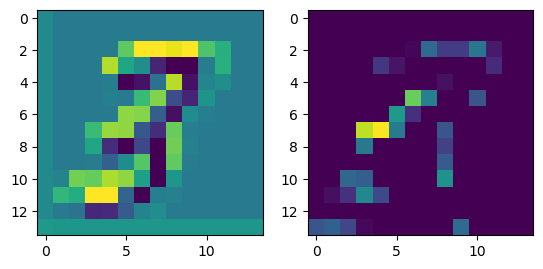

prediction: tensor([7, 2, 8]), tensor([2.2147, 1.4955, 1.1467]) groudtruth: 2
-0.039486904 0.018904582


<Figure size 640x480 with 0 Axes>

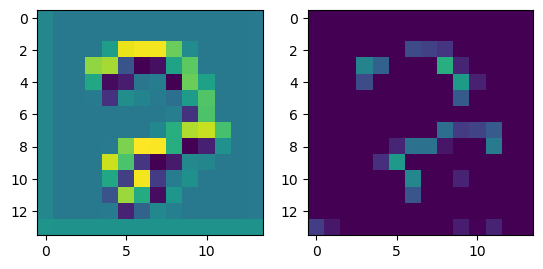

prediction: tensor([8, 4, 5]), tensor([1.4978, 1.3294, 0.5724]) groudtruth: 4
-0.028771905 0.01928794


<Figure size 640x480 with 0 Axes>

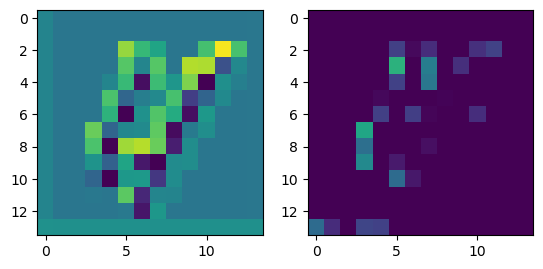

prediction: tensor([3, 5, 2]), tensor([1.5679, 0.7565, 0.7205]) groudtruth: 5
-0.036697727 0.020630818


<Figure size 640x480 with 0 Axes>

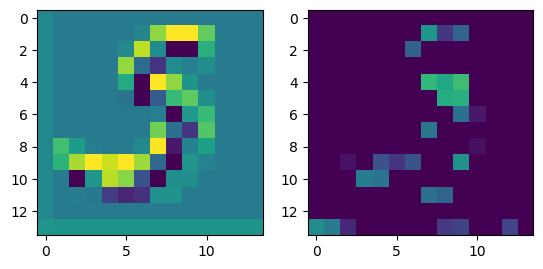

prediction: tensor([6, 0, 2]), tensor([1.7269, 1.2912, 0.7902]) groudtruth: 0
-0.028256055 0.02783123


<Figure size 640x480 with 0 Axes>

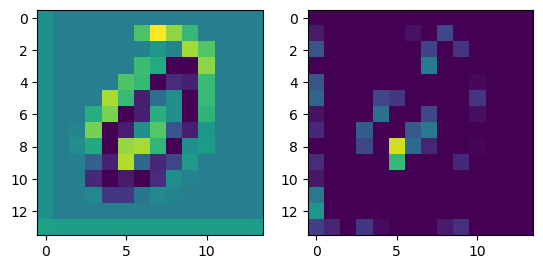

prediction: tensor([3, 2, 8]), tensor([2.5702, 2.0970, 1.0518]) groudtruth: 2
-0.034142617 0.034015328


<Figure size 640x480 with 0 Axes>

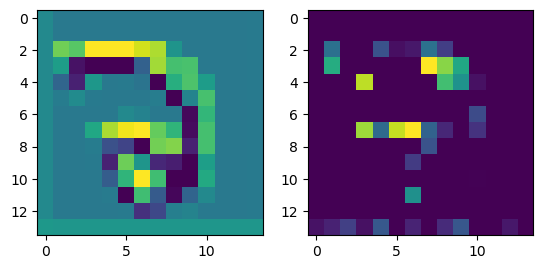

prediction: tensor([0, 2, 3]), tensor([3.0194, 2.7514, 1.8716]) groudtruth: 2
-0.026472656 0.027549965


<Figure size 640x480 with 0 Axes>

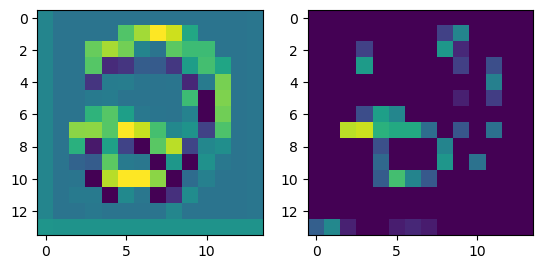

prediction: tensor([8, 7, 9]), tensor([2.1346, 1.9009, 1.4480]) groudtruth: 9
-0.024513729 0.020893145


<Figure size 640x480 with 0 Axes>

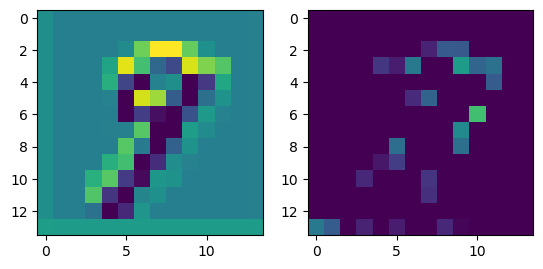

prediction: tensor([7, 9, 8]), tensor([2.7301, 2.4880, 1.7892]) groudtruth: 9
-0.0278421 0.022895928


<Figure size 640x480 with 0 Axes>

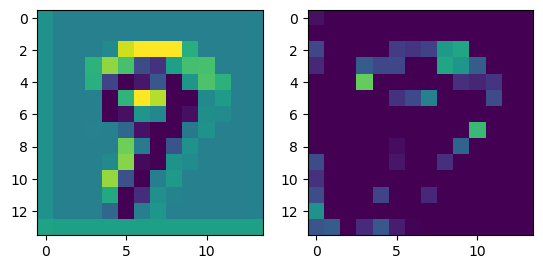

prediction: tensor([2, 0, 3]), tensor([3.1059, 2.2995, 1.3755]) groudtruth: 3
-0.042791646 0.032473512


<Figure size 640x480 with 0 Axes>

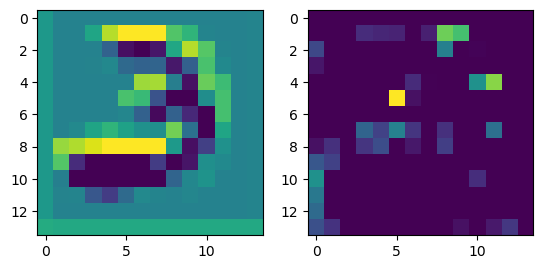

prediction: tensor([3, 8, 0]), tensor([2.4758, 2.3379, 0.8574]) groudtruth: 8
-0.035684206 0.019071726


<Figure size 640x480 with 0 Axes>

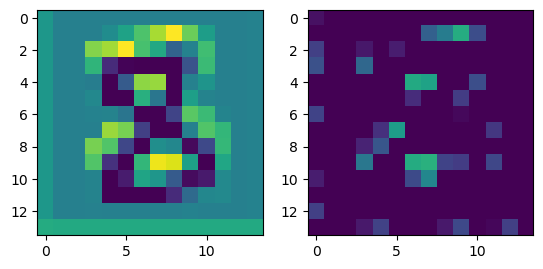

prediction: tensor([2, 3, 9]), tensor([1.9945, 1.4145, 0.3478]) groudtruth: 3
-0.021427697 0.022005975


<Figure size 640x480 with 0 Axes>

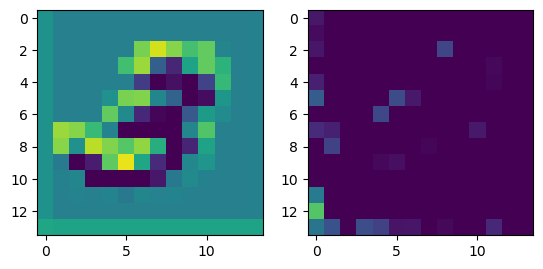

prediction: tensor([9, 2, 4]), tensor([2.1321, 1.8513, 1.2731]) groudtruth: 2
-0.03097625 0.027276564


<Figure size 640x480 with 0 Axes>

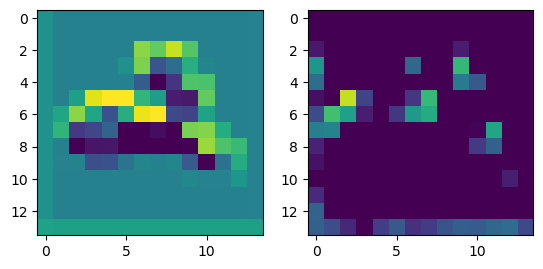

prediction: tensor([6, 4, 2]), tensor([2.0080, 1.6683, 1.2485]) groudtruth: 2
-0.02875162 0.033072587


<Figure size 640x480 with 0 Axes>

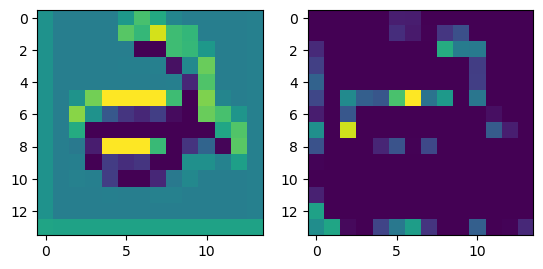

prediction: tensor([7, 9, 8]), tensor([3.0066, 2.8730, 1.3055]) groudtruth: 9
-0.032204658 0.022477169


<Figure size 640x480 with 0 Axes>

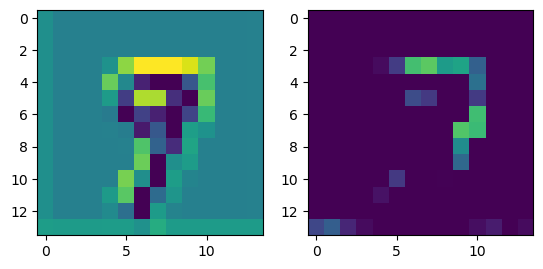

prediction: tensor([2, 8, 7]), tensor([1.9750, 1.9524, 1.6589]) groudtruth: 7
-0.026378727 0.017600572


<Figure size 640x480 with 0 Axes>

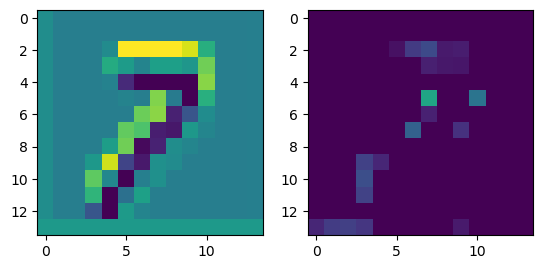

prediction: tensor([3, 5, 8]), tensor([2.9015, 2.3140, 1.7646]) groudtruth: 5
-0.026684452 0.020876713


<Figure size 640x480 with 0 Axes>

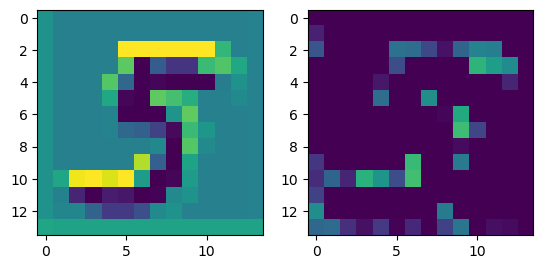

prediction: tensor([9, 4, 2]), tensor([2.2203, 1.8461, 1.2563]) groudtruth: 2
-0.031982653 0.02898469


<Figure size 640x480 with 0 Axes>

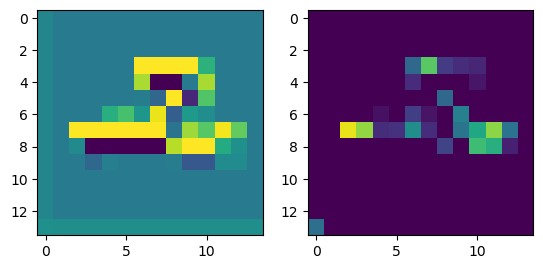

prediction: tensor([9, 8, 6]), tensor([2.0348, 1.7790, 0.9683]) groudtruth: 8
-0.029538011 0.02724735


<Figure size 640x480 with 0 Axes>

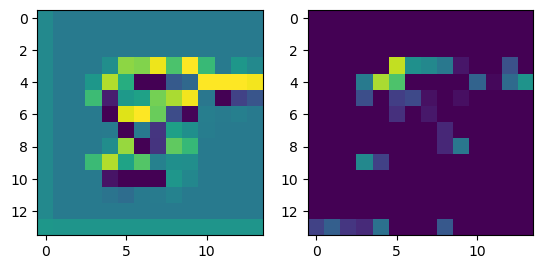

prediction: tensor([0, 5, 6]), tensor([1.5882, 1.4002, 1.3781]) groudtruth: 5
-0.048711225 0.030261816


<Figure size 640x480 with 0 Axes>

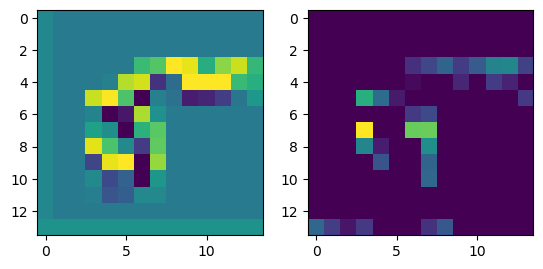

prediction: tensor([4, 9, 7]), tensor([3.0339, 2.8990, 1.3093]) groudtruth: 9
-0.028636528 0.026380088


<Figure size 640x480 with 0 Axes>

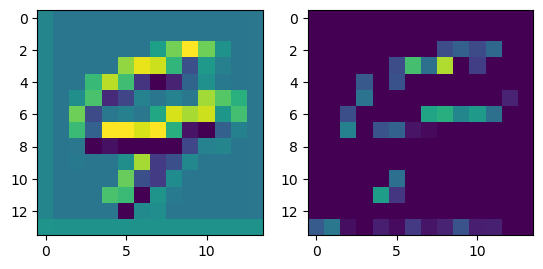

prediction: tensor([8, 1, 2]), tensor([1.7629, 1.6018, 1.3555]) groudtruth: 1
-0.03303825 0.020559832


<Figure size 640x480 with 0 Axes>

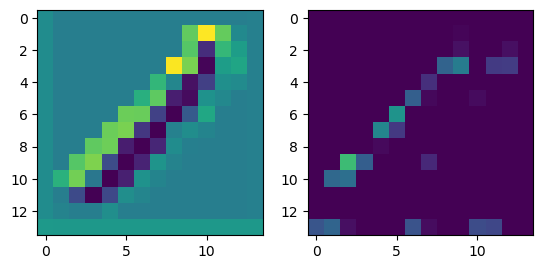

prediction: tensor([6, 0, 5]), tensor([2.0550, 1.4174, 1.1619]) groudtruth: 0
-0.023196861 0.016985254


<Figure size 640x480 with 0 Axes>

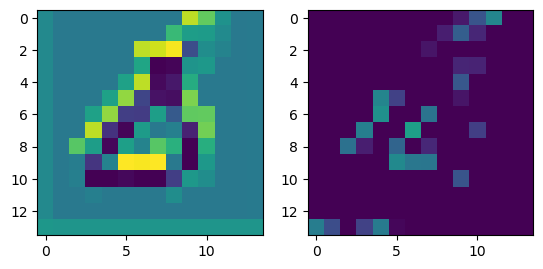

prediction: tensor([2, 6, 0]), tensor([2.8816, 2.4042, 1.5601]) groudtruth: 6
-0.020285046 0.019567618


<Figure size 640x480 with 0 Axes>

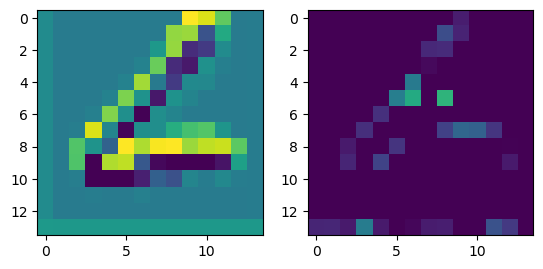

prediction: tensor([7, 9, 8]), tensor([3.9639, 2.3004, 0.6201]) groudtruth: 9
-0.02715614 0.037326347


<Figure size 640x480 with 0 Axes>

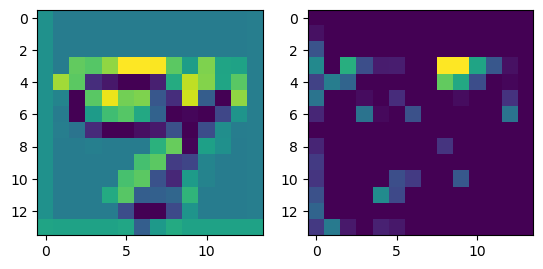

prediction: tensor([0, 3, 5]), tensor([3.9472, 3.2820, 0.9687]) groudtruth: 3
-0.024383202 0.022006176


<Figure size 640x480 with 0 Axes>

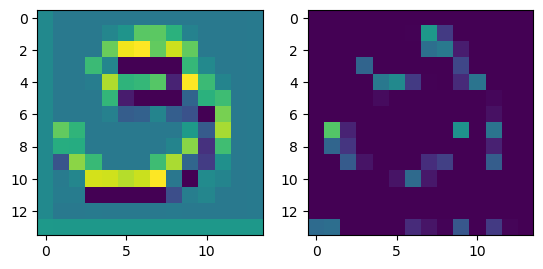

prediction: tensor([0, 5, 8]), tensor([3.0517, 1.8514, 1.7993]) groudtruth: 8
-0.043868884 0.034573503


<Figure size 640x480 with 0 Axes>

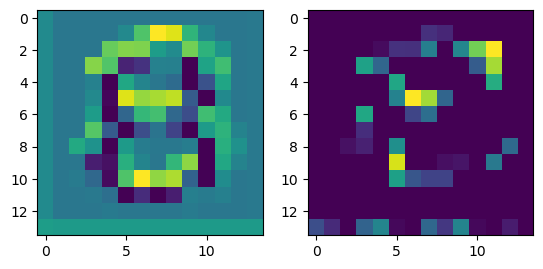

prediction: tensor([7, 9, 3]), tensor([3.0959, 2.1102, 1.6684]) groudtruth: 9
-0.02639706 0.030985001


<Figure size 640x480 with 0 Axes>

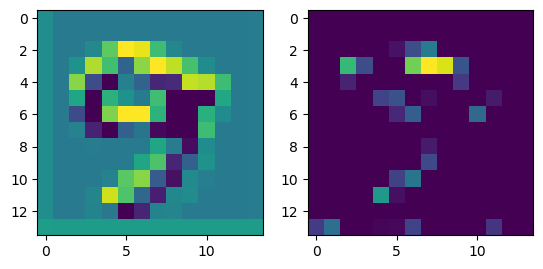

prediction: tensor([9, 7, 4]), tensor([2.8772, 1.5518, 1.5141]) groudtruth: 4
-0.023446891 0.024694597


<Figure size 640x480 with 0 Axes>

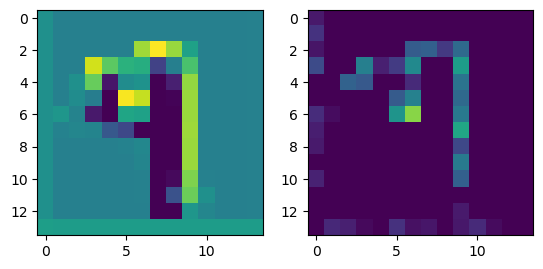

prediction: tensor([6, 8, 2]), tensor([2.5765, 1.4016, 1.1900]) groudtruth: 8
-0.029925672 0.021268297


<Figure size 640x480 with 0 Axes>

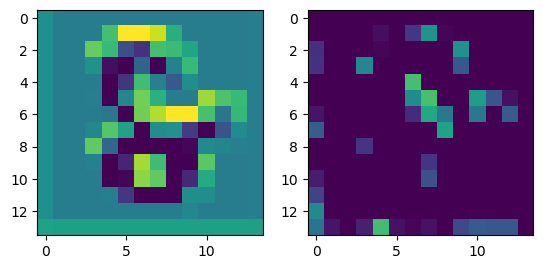

prediction: tensor([9, 4, 6]), tensor([2.2857, 1.5600, 1.2376]) groudtruth: 4
-0.024542475 0.028600113


<Figure size 640x480 with 0 Axes>

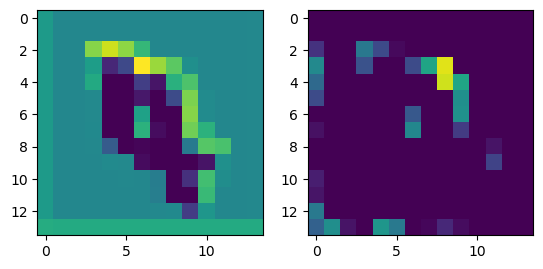

prediction: tensor([0, 6, 2]), tensor([2.3548, 2.3010, 1.2205]) groudtruth: 6
-0.019377798 0.028456924


<Figure size 640x480 with 0 Axes>

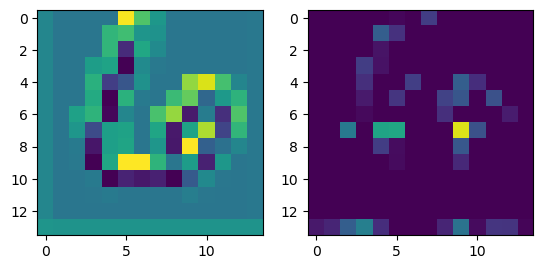

prediction: tensor([4, 2, 5]), tensor([1.5138, 1.3373, 0.8602]) groudtruth: 2
-0.029624695 0.028479606


<Figure size 640x480 with 0 Axes>

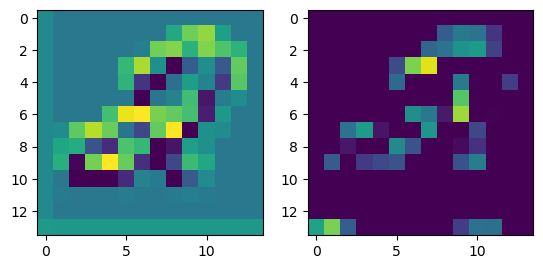

prediction: tensor([2, 8, 3]), tensor([3.6770, 1.7084, 0.6464]) groudtruth: 7
-0.02207375 0.014510481


<Figure size 640x480 with 0 Axes>

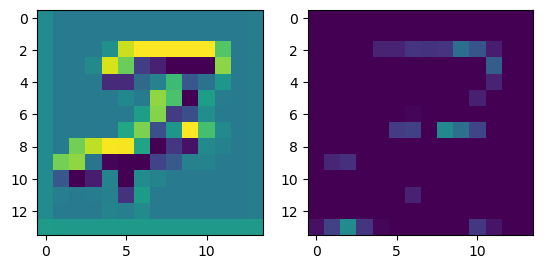

prediction: tensor([4, 9, 7]), tensor([3.4383, 2.8292, 0.6556]) groudtruth: 9
-0.026516404 0.027170595


<Figure size 640x480 with 0 Axes>

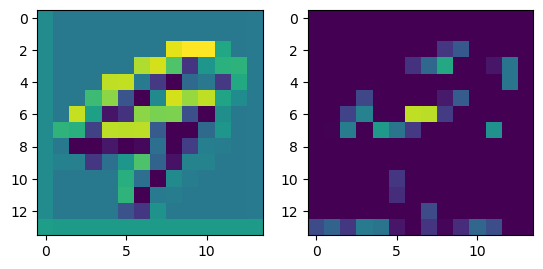

prediction: tensor([8, 5, 3]), tensor([1.5441, 1.2592, 1.1789]) groudtruth: 3
-0.03562727 0.021648917


<Figure size 640x480 with 0 Axes>

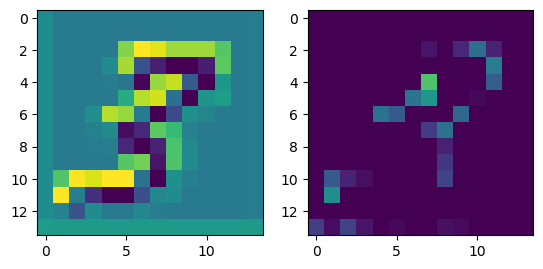

prediction: tensor([2, 7, 8]), tensor([2.7826, 1.7251, 1.2677]) groudtruth: 7
-0.027969658 0.018648539


<Figure size 640x480 with 0 Axes>

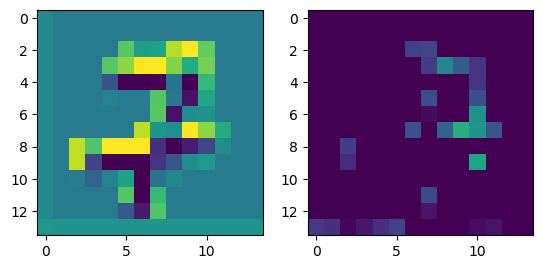

prediction: tensor([2, 8, 3]), tensor([3.4656, 2.0718, 0.5410]) groudtruth: 7
-0.032665797 0.021009497


<Figure size 640x480 with 0 Axes>

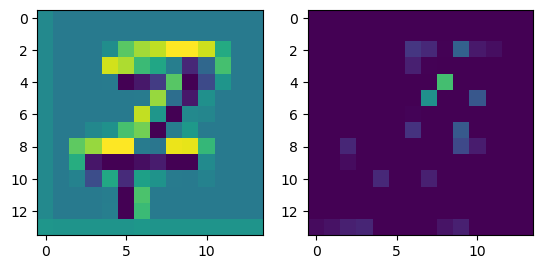

prediction: tensor([9, 8, 4]), tensor([1.1692, 0.9628, 0.9051]) groudtruth: 4
-0.038550958 0.026001722


<Figure size 640x480 with 0 Axes>

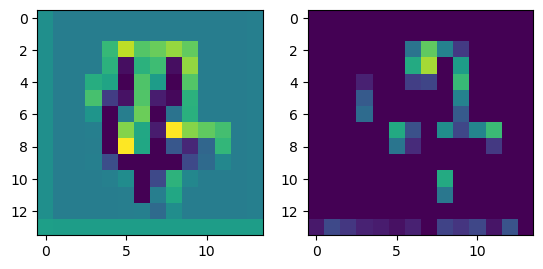

prediction: tensor([3, 8, 5]), tensor([1.7820, 1.7044, 0.9761]) groudtruth: 8
-0.047077466 0.025964271


<Figure size 640x480 with 0 Axes>

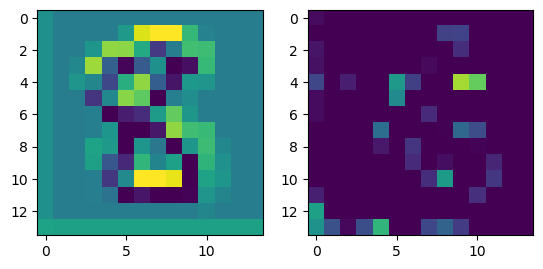

prediction: tensor([8, 2, 7]), tensor([1.9586, 1.8706, 0.6049]) groudtruth: 2
-0.03360176 0.028336518


<Figure size 640x480 with 0 Axes>

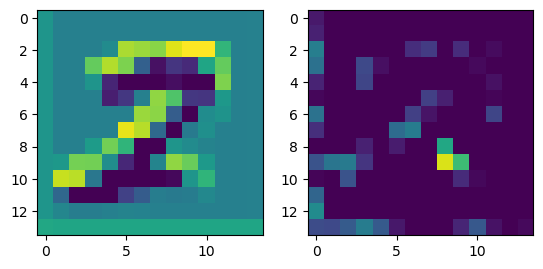

prediction: tensor([2, 3, 5]), tensor([1.6970, 1.3529, 0.8797]) groudtruth: 3
-0.02642404 0.017811477


<Figure size 640x480 with 0 Axes>

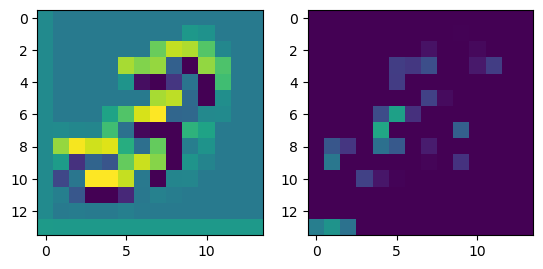

prediction: tensor([5, 8, 3]), tensor([2.3138, 1.9994, 1.6968]) groudtruth: 8
-0.028064951 0.025908755


<Figure size 640x480 with 0 Axes>

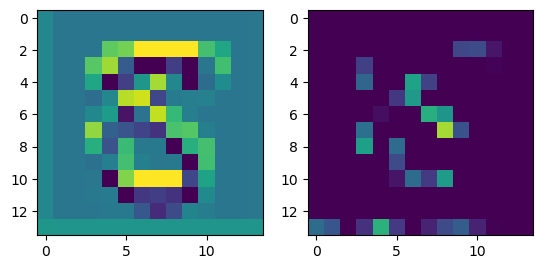

prediction: tensor([3, 5, 8]), tensor([2.1458, 2.1158, 2.0767]) groudtruth: 5
-0.029323492 0.026575789


<Figure size 640x480 with 0 Axes>

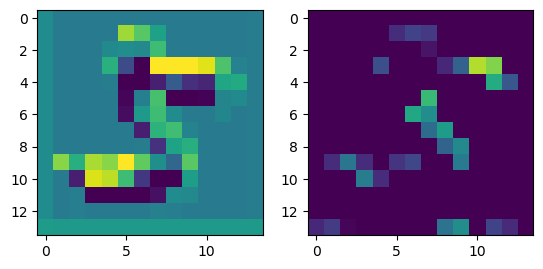

prediction: tensor([9, 4, 8]), tensor([1.8397, 1.7473, 1.7143]) groudtruth: 4
-0.02595713 0.022890821


<Figure size 640x480 with 0 Axes>

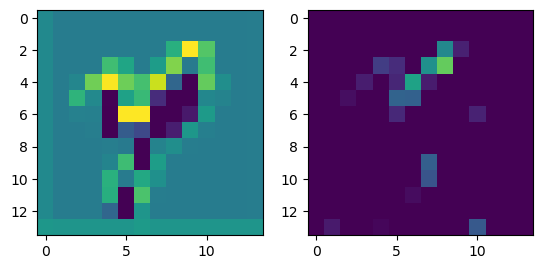

prediction: tensor([8, 7, 9]), tensor([2.2889, 1.8404, 1.6202]) groudtruth: 9
-0.02818868 0.027952101


<Figure size 640x480 with 0 Axes>

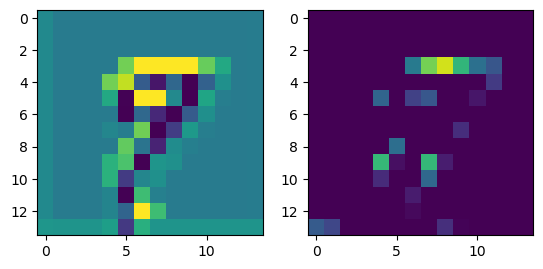

prediction: tensor([7, 9, 8]), tensor([1.8691, 1.6126, 1.2629]) groudtruth: 9
-0.027768973 0.01527217


<Figure size 640x480 with 0 Axes>

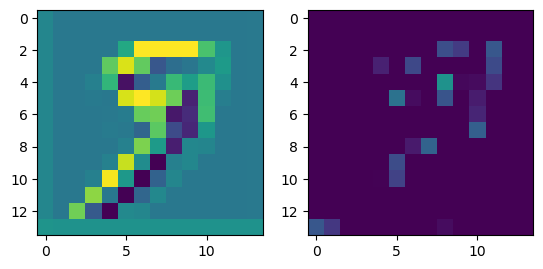

prediction: tensor([8, 7, 2]), tensor([1.2756, 1.1885, 0.8630]) groudtruth: 2
-0.026702346 0.035080537


<Figure size 640x480 with 0 Axes>

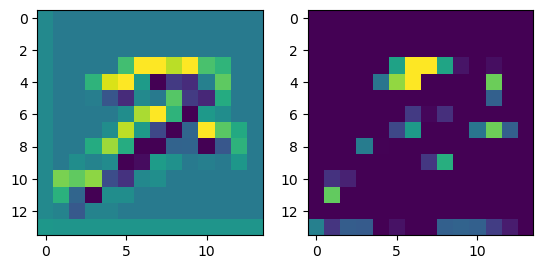

prediction: tensor([8, 5, 3]), tensor([2.5464, 1.9062, 1.4184]) groudtruth: 3
-0.030786453 0.024787035


<Figure size 640x480 with 0 Axes>

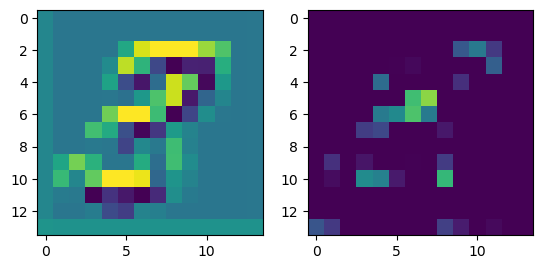

prediction: tensor([6, 5, 4]), tensor([1.6215, 0.8763, 0.6335]) groudtruth: 5
-0.026507707 0.034230907


<Figure size 640x480 with 0 Axes>

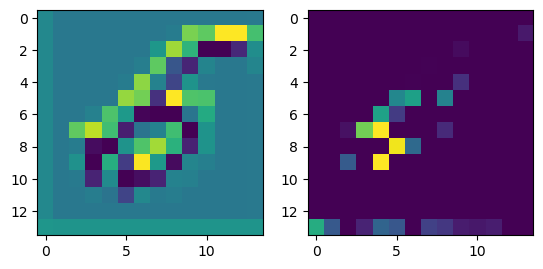

prediction: tensor([7, 8, 5]), tensor([1.7810, 1.6224, 1.1286]) groudtruth: 9
-0.024125237 0.017988298


<Figure size 640x480 with 0 Axes>

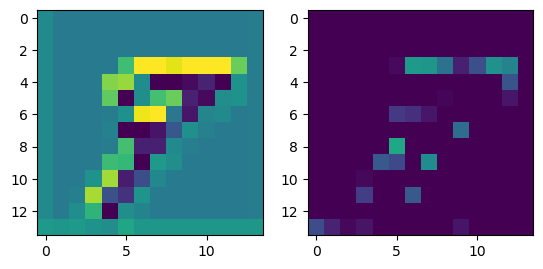

prediction: tensor([4, 9, 7]), tensor([2.2798, 2.1549, 1.3522]) groudtruth: 9
-0.028405115 0.026354063


<Figure size 640x480 with 0 Axes>

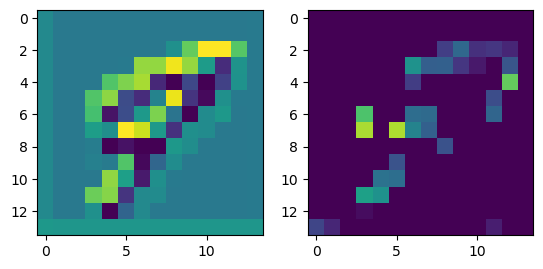

prediction: tensor([7, 9, 4]), tensor([1.4415, 1.2715, 1.2653]) groudtruth: 9
-0.026001742 0.027799763


<Figure size 640x480 with 0 Axes>

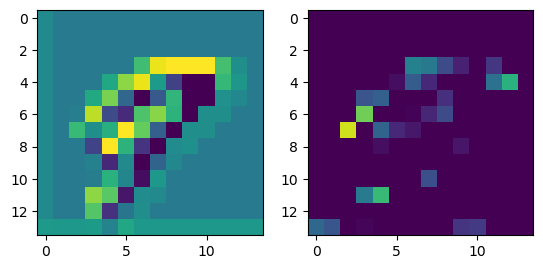

prediction: tensor([1, 4, 8]), tensor([1.6554, 1.0604, 1.0469]) groudtruth: 4
-0.018918557 0.014009426


<Figure size 640x480 with 0 Axes>

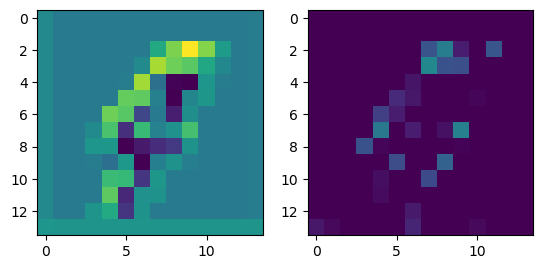

prediction: tensor([5, 9, 7]), tensor([3.1099, 1.7827, 1.6144]) groudtruth: 9
-0.026411049 0.035518326


<Figure size 640x480 with 0 Axes>

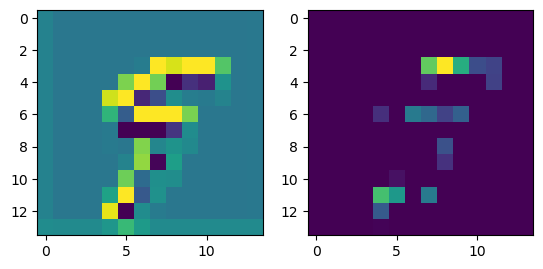

prediction: tensor([1, 8, 6]), tensor([1.8192, 1.0887, 1.0741]) groudtruth: 6
-0.024536444 0.020857753


<Figure size 640x480 with 0 Axes>

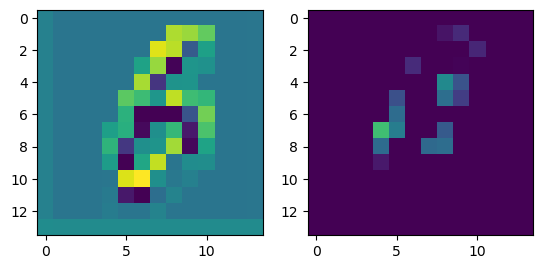

prediction: tensor([8, 5, 7]), tensor([2.6896, 0.8469, 0.6135]) groudtruth: 2
-0.033799145 0.030200385


<Figure size 640x480 with 0 Axes>

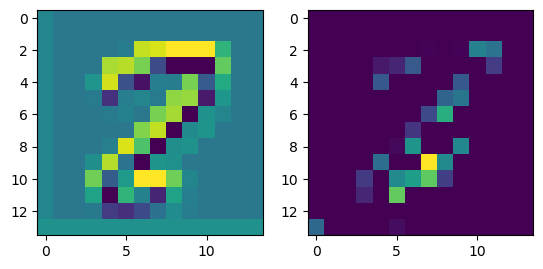

prediction: tensor([4, 9, 5]), tensor([3.0504, 2.4582, 1.0501]) groudtruth: 9
-0.027799051 0.020730685


<Figure size 640x480 with 0 Axes>

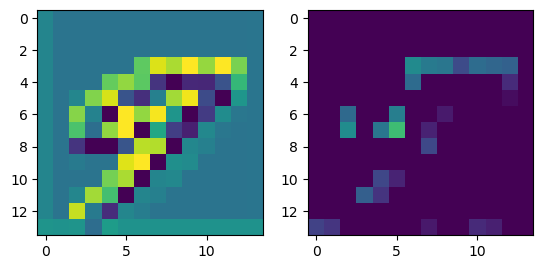

prediction: tensor([8, 5, 9]), tensor([1.4122, 0.9048, 0.6079]) groudtruth: 3
-0.028102105 0.02541576


<Figure size 640x480 with 0 Axes>

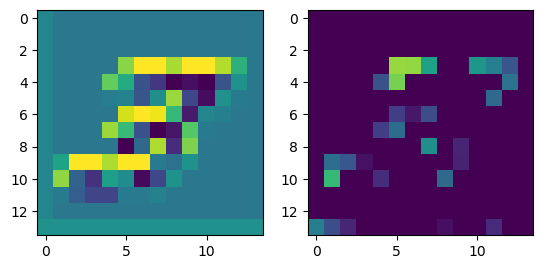

prediction: tensor([8, 7, 2]), tensor([1.8070, 1.4637, 1.3074]) groudtruth: 2
-0.03443691 0.01830623


<Figure size 640x480 with 0 Axes>

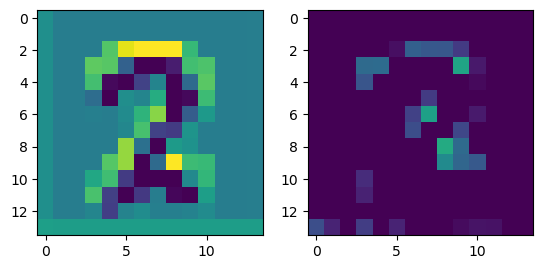

prediction: tensor([9, 4, 8]), tensor([2.2023, 1.9613, 1.3518]) groudtruth: 4
-0.024840923 0.02507457


<Figure size 640x480 with 0 Axes>

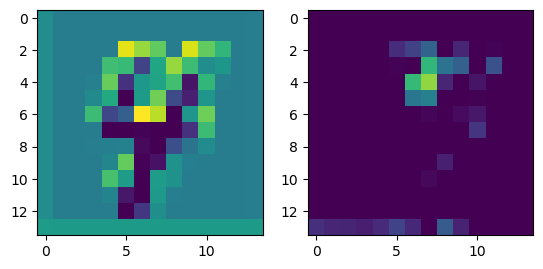

In [67]:
import matplotlib.pyplot as plt

for data, target in test_loader: 

    a1, a2, a3, a4 = forward_model(data)
    s1, s2, s3 = backward_model(target, use_act_derivative=True)
    # p = torch.argmax(a4, dim=-1)
    p = torch.topk(a4, k=3, dim=-1).indices
    v = torch.topk(a4, k=3, dim=-1).values

    for i1 in range(16):

        if p[i1][0] != target[i1]:

            i2 = 11
            print(f"prediction: {p[i1]}, {v[i1].detach()} groudtruth: {target[i1]}")

            plt.figure()
            fig, axes = plt.subplots(1,2)

            X = a1.detach().cpu()
            # X = X / X.norm()
            X = X.numpy()


            axes[0].imshow(X[i1,i2], vmin=-1, vmax=1)

            X = s1.detach().cpu()
            # X = X / X.norm()
            X = X.numpy()
            print(X[i1,i2].min(), X[i1,i2].max())

            axes[1].imshow(X[i1,i2], vmin=-0.0, vmax=0.03)
            plt.pause(0.2)

tensor([8, 3, 2, 8, 1, 2, 0, 7, 1, 0, 4, 4, 5, 8, 0, 6, 2, 3, 1, 5, 1, 8, 5, 9,
        4, 0, 7, 5, 8, 8, 3, 2, 9, 2, 6, 2, 5, 3, 1, 7, 2, 2, 1, 9, 9, 6, 0, 3,
        4, 2, 8, 1, 4, 5, 5, 2, 9, 2, 5, 8, 9, 5, 0, 1])

0.0 0.0054241167


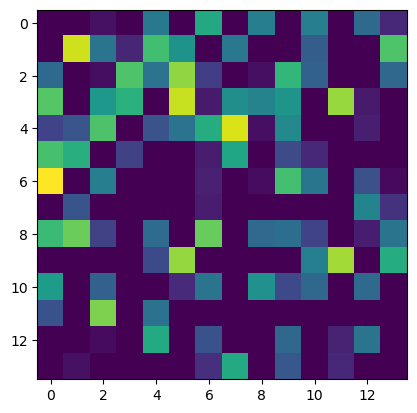

In [23]:
## import matplotlib.pyplot as plt

backward_model = BackwardModel()
s1, s2, s3 = backward_model(target)

i1, i2 = 7, 2
X = s1.detach().cpu()
X = X / X.norm()
X = X.numpy()
print(X[i1,i2].min(), X[i1,i2].max())
plt.imshow(X[i1,i2])

0.0 0.0056584203


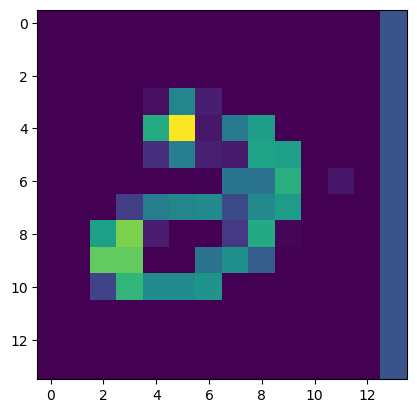

In [19]:
i1, i2 = 0, 6
X = a1.detach().cpu()
X = X / X.norm()
X = X.numpy()
print(X[i1,i2].min(), X[i1,i2].max())
plt.imshow(X[i1,i2])

In [ ]:
s2.shape